#### Importing Libraries

In [360]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import math
import joblib
from sklearn.metrics import mean_squared_error, mean_pinball_loss, r2_score, classification_report, confusion_matrix, mean_absolute_percentage_error
from imblearn.over_sampling import SMOTENC
import lightgbm as lgb
import json


#### Constants

In [361]:
PATH_TO_CVS = 'output/output-energy/'
GROUP_FILE_PATH = 'group_list.json'
# This constant contains the unique quantile to represent in the scatter plot of residuals 
ONLY_QUANTILE = 0.95
# Constant containing the partial name of all the metric of a function
FUNCTION_COLUMNS = ['rate_function_', 'success_rate_function_', 'cpu_usage_function_', 'ram_usage_function_', 'power_usage_function_', 'replica_', 'overloaded_function_', 'medium_latency_function_']
# A selection of node metrics to represent in the boxplot and in the scatter plot 
COL_TO_PLOT = ['cpu_usage_idle_node', 'cpu_usage_node', 'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node', 'power_usage_node']
# List containing the values whose quantile regression is to be calculated
QUANTILES = [0.05, 0.95]
NODE_TYPES = ["LIGHT", "MID", "HEAVY"]
# List of functions to be considered only for predictions
PREDICT_ONLY_FUNCTIONS = []
#
SEED = 4850
NUM_TRAINING_EXPERIMENTS = 5

#### Utilities functions

In [362]:
# Function used to fill NaN values within the dataframe X
def fill_NaN(X):
  for col in X:
    if(col.startswith('success_rate_')):
      X.loc[:, col] = X.loc[:, col].fillna(1)
    else:
      X.loc[:, col] = X.loc[:, col].fillna(0)
  return X

In [363]:
# Function to reweight of dataframe
def resample_dataset(X, y):
  X_resampled, y_resampled = resample(X, y, replace=True, random_state=42)
  return X_resampled, y_resampled

In [364]:
# Function used to split the dataset into training and test set
def split_dataset(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [365]:
def convert_dataset(X_train, X_test, y_train, y_test):
  X_train_nn = X_train.astype(np.float32)
  X_test_nn = X_test.astype(np.float32)
  y_train_nn = y_train.astype(np.float32)
  y_test_nn = y_test.astype(np.float32)
  
  return X_train_nn, X_test_nn, y_train_nn, y_test_nn

In [366]:
# Function used to calculate the weighted mean squared error
def wmse_score(y_true, y_pred):
  # Calculates the weight of classes for the first target  
  median_cpu = y_true['cpu_usage_node'].median()
  w_majority_cpu = y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] / y_true.shape[0]
  w_minority_cpu = y_true[y_true['cpu_usage_node'] > median_cpu].shape[0] / y_true.shape[0]

  # Calculate the weight of classes for the second target
  median_ram = y_true['ram_usage_node'].median()
  w_majority_ram = y_true[y_true['ram_usage_node'] <= median_ram].shape[0] / y_true.shape[0]
  w_minority_ram = y_true[y_true['ram_usage_node'] > median_ram].shape[0] / y_true.shape[0]

  # Calculates the MSE for both targets
  mse_cpu = mean_squared_error(y_true['cpu_usage_node'], y_pred['cpu_usage_node'])
  mse_ram = mean_squared_error(y_true['ram_usage_node'], y_pred['ram_usage_node'])

  # Calculates WMSE as a weighted average of the MSEs for the two targets
  wmse = (w_majority_cpu * mse_cpu * y_true.shape[0] / (w_majority_cpu * y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] + w_minority_cpu * y_true[y_true['cpu_usage_node'] > median_cpu].shape[0]) +
          w_majority_ram * mse_ram * y_true.shape[0] / (w_majority_ram * y_true[y_true['ram_usage_node'] <= median_ram].shape[0] + w_minority_ram * y_true[y_true['ram_usage_node'] > median_ram].shape[0])) / 2

  return wmse

In [367]:
# Function used to calculate metrics based on the task
def metrics(task_type, y_test, y_pred, quantile):
  if(task_type == 'regression'):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print("mape:", mape)
    mse = mean_squared_error(y_test, y_pred)
    print("mse:", mse)
    rmse = math.sqrt(mse)
    print("rmse:", rmse)
    r2 = r2_score(y_test, y_pred)
    print("R-squared score:", r2)
    std_dev = float(np.std(y_pred))
    print("Standard deviation:", std_dev)
    if quantile != 0:
      quantile_loss = mean_pinball_loss(y_test, y_pred, alpha=quantile)
      print("Quantile loss with library: ", quantile_loss)
    else:
      quantile_loss = "Not calculated for this target"
    return {"mape": mape, "mse": mse, "rmse": rmse, "r2": r2, "quantile_loss": quantile_loss, "std_dev": std_dev}    
  elif(task_type.endswith('classification')):
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    return {}

In [368]:
# Function used to plot the regression lines for the 2 targets
def plot_regression(y_test, y_pred, target_name, plot_folder = None):
    # Calculate the regression lines
    m, q = np.polyfit(y_test.ravel(), y_pred.ravel(), 1)

    # Plot the regression lines
    plt.plot(y_test, y_pred, 'o', color='red', fillstyle='none')
    plt.plot(y_test, m*y_test + q, linestyle='--')
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Predicted values', fontsize = 14)
    plt.title('Regression of ' + target_name)
    plt.xlim(0, 1)  
    plt.ylim(0, 1)  
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

    # Calculate residuals 
    residuals = y_test.flatten() - y_pred.flatten()

    # Scatter plot with regression line
    sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Observations')

    # Add the horizontal line near the value 0.0 of the y-axis
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Residuals (Observed - Predicted values)')
    plt.title(f'Standard Regression - {target_name}')
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}_residuals.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

In [369]:
# Function used to plots quantile regression results.
def plot_quantile_regression(y_test, y_pred, target_name, plot_folder = None):
    point = 1
    line = 3
    for col in y_pred:
        m, q = np.polyfit(y_test.ravel(), y_pred[col], 1)
        plt.plot(y_test, y_pred[col], 'o', fillstyle='none', label=f'Observations - {col}')
        plt.plot(y_test, m*y_test + q, linestyle='--', zorder = line)
        point = point + 1
        line = line + 1
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Predicted values', fontsize = 14)
    plt.title('Quantile Regression of ' + target_name)
    plt.xlim(0, 1)  
    plt.ylim(0, 1)  
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}_quantile.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

    # Calculate quantile residuals
    residuals = y_test.flatten() - y_pred[str(ONLY_QUANTILE)]

    # Scatter plot with regression line
    sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Observations')

    # Add the horizontal line near the value 0.0 of the y-axis
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Quantile residuals (Observed - Predicted values)')
    plt.title(f'Quantile Regression {ONLY_QUANTILE} - {target_name}')
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}_quantile_residuals.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

In [370]:
# Function used to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, target):
  # Calculate the confusion matrix
  cm = confusion_matrix(y_test[target], y_pred[target])

  # Plot the confusion matrix as heatmap
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Valori osservati')
  plt.ylabel('Valori predetti')
  plt.title('Confusion matrix')
  plt.show()

In [371]:
# Function used to train the desired model for a target variable
def train_model(target_name, X_train, y_train, quantile):
    # Classification task. Create model with autogluon
    if target_name.startswith('overloaded') or target_name.startswith('replica'):
        model_type = ""
        model = lgb.LGBMClassifier()
    # Quantile regression with LGBM
    elif quantile != 0:
        model = lgb.LGBMRegressor(objective='quantile', alpha=quantile)
        model_type = "quantile" + str(quantile).replace('.', '')
    # Regression with LGBM
    else:
        model = lgb.LGBMRegressor(objective='regression')
        model_type = "regression"
    
    model.fit(X_train, y_train)
    path = './system-forecaster-models/groups/' + target_name + "/" + model_type
    if not os.path.exists(path):
        os.makedirs(path)
    joblib.dump(model, path + "/model.joblib")

    return model



In [372]:
# Function to obtain a barchart of the type of nodes
def plot_node_type_distribution(df):
    """
    Visualizza il numero di dati per ogni tipologia di nodo in un DataFrame tramite un bar chart.

    :param df: DataFrame contenente la colonna 'node_type' con le tipologie di nodo.
    """
    # Count of occurrences for each node type
    node_counts = df['node_type'].value_counts()

    # Bar chart
    plt.figure(figsize=(10, 6))
    node_counts.plot(kind='bar')
    plt.title('Distribuzione del Numero di Dati per Tipologia di Nodo')
    plt.xlabel('Tipologia di Nodo (0 = Heavy, 1 = Mid, 2 = Light)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  # Maintains names of horizontal node types
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [373]:
# Function to obtain a barchart of overloaded node distribution
def plot_overloaded_node_distribution(df):
    """
    Visualizza il numero di righe in cui 'overloaded_node' è 1 e quelle in cui è 0.

    :param df: DataFrame contenente la colonna 'overloaded_node'.
    """
    # Count of occurrences of 0 and 1 in the 'overloaded_node' column
    overloaded_counts = df['overloaded_node'].value_counts()

    # Bar chart
    plt.figure(figsize=(8, 5))
    overloaded_counts.plot(kind='bar')
    plt.title('Distribuzione di Nodi Sovraccaricati')
    plt.xlabel('Stato Sovraccarico (0 = No, 1 = Sì)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [374]:
# Create a dataset where the 0 values in the selected columns are replaced with NaN
def create_df_no_zeros(df, temp_columns, metric, df_groups, col_name, key):
    df_no_zeros = df[temp_columns].mask(df[temp_columns] == 0)
    if (metric.__contains__('rate') or metric.__contains__('usage') or metric.__contains__('power') or metric.__contains__('replica')) and not metric.__contains__('success'):
        df_groups[col_name + key] = df[temp_columns].sum(axis=1)
    elif metric.__contains__('overloaded'):
        df_groups[col_name + key] = df[temp_columns].any(axis=1).astype(int)
    else:
        df_groups[col_name + key] = df_no_zeros.mean(axis=1)
    return df_groups

In [375]:
# Function to split train/test sets
def build_train_test_data(targets, target_datasets, features_datasets, targets_pred, target_datasets_pred, features_datasets_pred):
    # Initialize dictionaries to store scaled data and train-test splits
    x_train_dict = {}
    x_test_dict = {}
    y_train_dict = {}
    y_test_dict = {}
    y_scalers = {}
    scaler_exist = False

    for target_name in targets:
        # Get the target dataset for the current iteration
        target_dataset = target_datasets[target_name]

        # Apply scaling for x (features)
        X = features_datasets[target_name]
        scaler_x = MinMaxScaler()
        scaler_x.fit(X)
        X_scaled = scaler_x.transform(X)

        # Apply scaling for y (target)
        scaler_y = MinMaxScaler()
        scaler_y.fit(target_dataset)
        y_scalers[target_name] = scaler_y
        if target_name.startswith('overloaded') or target_name.startswith('replica'):
            y_scaled = target_dataset
        else:
            y_scaled = scaler_y.transform(target_dataset)

        # Save the scaler for x
        scaler_x_path = './scalers/groups/scaler_x/' 
        if not os.path.exists(scaler_x_path):
            os.makedirs(scaler_x_path)
        if target_name.startswith('overloaded'):
            joblib.dump(scaler_x, scaler_x_path + "/" + target_name + ".joblib")
        elif not scaler_exist:
            scaler_exist = True
            joblib.dump(scaler_x, scaler_x_path + "/features.joblib")

        # Save the scaler for y
        scaler_y_path = './scalers/groups/scaler_y/'
        if not os.path.exists(scaler_y_path):
            os.makedirs(scaler_y_path)
        if not target_name.startswith("overloaded"):
            joblib.dump(scaler_y, scaler_y_path + "/" + target_name + ".joblib")

        # Split the dataset into training and testing
        x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled)
        x_train_dict[target_name] = x_train
        x_test_dict[target_name] = x_test
        y_train_dict[target_name] = y_train
        y_test_dict[target_name] = y_test

    # Predict-only
    x_test_dict_pred = {}
    y_test_dict_pred = {}
    for target_name in targets_pred:
        # Get the target dataset for the current iteration
        target_dataset = target_datasets_pred[target_name]
        
        # Apply scaling for x
        X = features_datasets_pred[target_name]
        scaler_x = joblib.load('./scalers/groups/scaler_x/features.joblib')
        X_scaled = scaler_x.transform(X)

        # Apply scaling for y (target)
        scaler_y = y_scalers[target_name]
        y_scaled = scaler_y.transform(target_dataset)

        x_test_dict_pred[target_name] = X_scaled
        y_test_dict_pred[target_name] = y_scaled
    
    return x_train_dict, x_test_dict, y_train_dict, y_test_dict, x_test_dict_pred, y_test_dict_pred, y_scalers

In [376]:
#Function to train One Model for each target variable
def train_all_models(targets, x_train_dict, y_train_dict):
    #Initialize a dictionary to store models
    trained_models = {}
    for target_name in targets:
        #Get the corresponding x_train for the current target
        x_train = x_train_dict[target_name]

        # Get the corresponding y_train for the current target
        y_train = y_train_dict[target_name]

        #Trains the specific model for the current target
        model = train_model(target_name, x_train, y_train, 0)  # Use the specific target's y_train
        trained_models[target_name] = model
        if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
            for quantile in QUANTILES:
                model = train_model(target_name, x_train, y_train, quantile)
                trained_models[target_name + " " + str(quantile)] = model
    return trained_models

In [377]:
# Function to compute predictions and evaluate all models
def evaluate_all_models(trained_models, targets, params, x_test_dict, y_test_dict):
    # Initialize dictionary to store predictions
    all_predictions = {}
    for target_name in targets:

        # Get the test dataset for the current iteration
        x_test = x_test_dict[target_name]
        y_test = y_test_dict[target_name]
        test_data = pd.DataFrame(np.column_stack((x_test, y_test)), columns=[*params, target_name])

        # Load trained model and predict
        model = trained_models[target_name]
        y_pred = model.predict(test_data.drop(columns=[target_name]))
        all_predictions[target_name] = y_pred
        if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
            y_pred_quantiles = {}
            for quantile in QUANTILES:
                model = trained_models[target_name + " " + str(quantile)]
                y_pred_quantiles[str(quantile)] = model.predict(test_data.drop(columns=[target_name]))
            all_predictions[target_name + " quantiles"] = y_pred_quantiles
    return all_predictions

In [378]:
# Function to compute prediction metrics and plot results
def compute_metrics_and_plot(all_predictions, y_test_dict, y_scalers, plot_folder = None):
    quantiles_string = [str(q) for q in QUANTILES]
    all_metrics = {}
    all_metrics_no_scale = {}
    for target_name, y_pred in all_predictions.items():
        print(f"Target: {target_name}")

        if target_name.startswith('overloaded'):
            task_type = 'binary classification'
        elif target_name.startswith('replica'):
            task_type = 'classification'
        else:
            task_type = 'regression'

        if target_name.endswith('quantiles'):
            # Get the test dataset for the current iteration
            trunc_target = target_name[0:target_name.index(' ')]
            y_test = y_test_dict[trunc_target]
            y_test_df = pd.DataFrame(y_test, columns=[trunc_target])
            y_pred_df = pd.DataFrame(y_pred, columns=quantiles_string)
            for quantile in QUANTILES:
                statistics = (y_pred_df[str(quantile)] > y_test_df[trunc_target]).value_counts(normalize=True)
                if statistics.size > 1:
                    true_percentage, false_percentage = statistics[True], statistics[False]
                    print(f"Prediction for alpha {quantile} are greater than true values in {true_percentage * 100} % of cases and less or equal in {false_percentage * 100} % of cases.")
                all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df[str(quantile)], quantile) 
            plot_quantile_regression(y_test, y_pred_df, trunc_target, plot_folder)            
            # metrics on non-scaled predictions
            y_test_df_not_scaled = pd.DataFrame()
            for col in y_test_df:
                y_test_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
            y_pred_df_not_scaled = pd.DataFrame()
            for col in y_pred_df:
                y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
            all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled[str(quantile)], quantile) 
        else:
            y_test = y_test_dict[target_name]
            y_test_df = pd.DataFrame(y_test, columns=[target_name])
            y_pred_df = pd.DataFrame(y_pred, columns=[target_name])
            all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df, 0)
            if task_type == 'regression':
                plot_regression(y_test, y_pred, target_name, plot_folder)   
            # metrics on non-scaled predictions
            y_test_df_not_scaled = pd.DataFrame()
            for col in y_test_df:
                y_test_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
            y_pred_df_not_scaled = pd.DataFrame()
            for col in y_pred_df:
                y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
            all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled, 0) 

        print("-" * 30)

    all_metrics = pd.DataFrame(all_metrics).transpose().sort_index()
    all_metrics["metric"] = all_metrics.index
    all_metrics_no_scale = pd.DataFrame(all_metrics_no_scale).transpose().sort_index()
    all_metrics_no_scale["metric"] = all_metrics_no_scale.index
    return all_metrics, all_metrics_no_scale

#### Retrieving dataset

In [379]:
df = pd.DataFrame()
for node_type in NODE_TYPES:
    # Retrieve all files in the output folder
    file_csv = [file for file in os.listdir(PATH_TO_CVS + node_type) if file.endswith('.csv')]
    # Create the dataframe by concatenating all read files
    dataframes = []
    for file in file_csv:
        file_path = os.path.join(PATH_TO_CVS + node_type, file)
        df_temp = pd.read_csv(file_path)       
        # Remove the columns in the dataframe that begin with "function_"
        df_temp.drop(columns=[col for col in df_temp if col.startswith('function_')], inplace=True)        
        # Aggiungi la colonna "node_type" e assegna il valore di 'type' a tutte le righe
        if node_type == "HEAVY":
            df_temp["node_type"] = 1
        elif node_type == "MID":
            df_temp["node_type"] = 2
        else: 
            df_temp["node_type"] = 3
        
        dataframes.append(df_temp)

    df = pd.concat([df, *dataframes], axis=0, ignore_index=True)

df = fill_NaN(df)
print(df["node_type"].value_counts())

functions = [col[14:] for col in df if col.startswith('rate')]

for function in functions:
    df.loc[df['rate_function_' + function] == 0, ['cpu_usage_function_' + function, 'ram_usage_function_' + function, 'power_usage_function_' + function, 'replica_' + function]] = 0


node_type
2    57000
3    22349
1    19435
Name: count, dtype: int64


In [380]:
df

rate_function_shasum  success_rate_function_shasum  \
0                     100.0                           1.0   
1                     100.0                           1.0   
2                     100.0                           1.0   
3                     100.0                           1.0   
4                     100.0                           1.0   
...                     ...                           ...   
98779                   0.0                           1.0   
98780                   0.0                           1.0   
98781                   0.0                           1.0   
98782                   0.0                           1.0   
98783                   0.0                           1.0   

       cpu_usage_function_shasum  ram_usage_function_shasum  \
0                          7.691                4042069.333   
1                          7.751                9199274.667   
2                          8.378                9214634.667   
3                          8.793                1366357.333   
4                          7.820                1323008.000   
...                          ...                        ...   
98779                      0.000                      0.000   
98780                      0.000                      0.000   
98781                      0.000                      0.000   
98782                      0.000                      0.000   
98783                      0.000                      0.000   

       power_usage_function_shasum  replica_shasum  \
0                        11739.653             2.0   
1                        16427.020             1.0   
2                        14245.149             2.0   
3                        24734.177             2.0   
4                        17732.391             2.0   
...                            ...             ...   
98779                        0.000             0.0   
98780                        0.000             0.0   
98781                        0.000             0.0   
98782                        0.000             0.0   
98783                        0.000             0.0   

       overloaded_function_shasum  medium_latency_function_shasum  \
0                             0.0                     107580927.0   
1                             0.0                      16880204.0   
2                             0.0                      35575151.0   
3                             0.0                      76360433.0   
4                             0.0                      87032021.0   
...                           ...                             ...   
98779                         0.0                             0.0   
98780                         0.0                             0.0   
98781                         0.0                             0.0   
98782                         0.0                             0.0   
98783                         0.0                             0.0   

       rate_function_curl  success_rate_function_curl  ...  \
0                    60.0                         1.0  ...   
1                    60.0                         1.0  ...   
2                    60.0                         1.0  ...   
3                    60.0                         1.0  ...   
4                    60.0                         1.0  ...   
...                   ...                         ...  ...   
98779                 0.0                         1.0  ...   
98780                 0.0                         1.0  ...   
98781                 0.0                         1.0  ...   
98782                 0.0                         1.0  ...   
98783                 0.0                         1.0  ...   

       overloaded_function_env  medium_latency_function_env  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0            

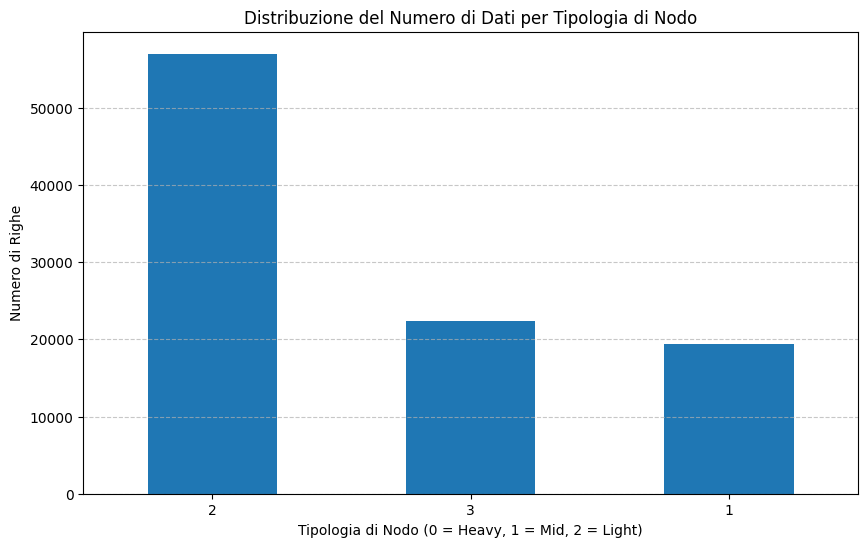

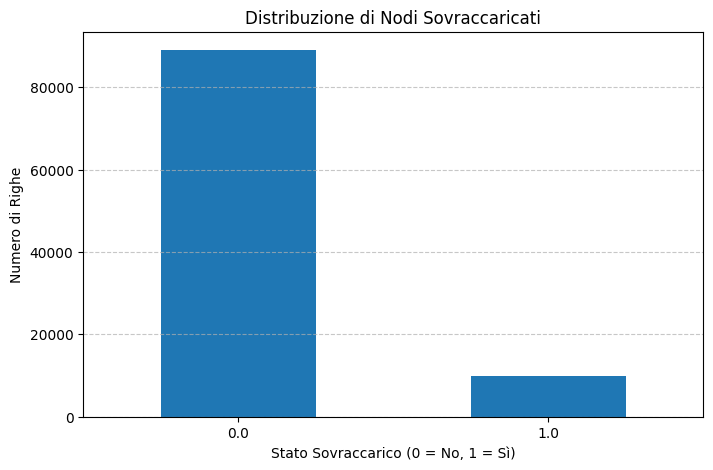

In [381]:
# Plot node type distribution
plot_node_type_distribution(df)
# Plot overloaded node distribution
plot_overloaded_node_distribution(df)

#### Removing outliers

In [382]:
# Iterate over each target column and handle outliers
functions_column = [col for col in df if col.startswith('rate')]
targets = [col for col in df if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]
grouped = df.groupby(functions_column + ['node_type'])
threshold = 1
for target in targets:
    print(target)
    if target != 'overloaded_node':
        mean = grouped[target].transform('mean')
        std = grouped[target].transform('std')
        outliers = (df[target] > mean + threshold * std) | (df[target] < mean - threshold * std)
        print(outliers.sum())
        df[target] = df[target].where(~outliers, mean)
    else:
        new_overloaded = grouped[target].transform('all')
        df['overloaded_node'] = new_overloaded.astype(int)
        print(df["overloaded_node"].value_counts())
df_only_useful = df[functions_column + targets + ["node_type"]]

cpu_usage_function_shasum
23887
ram_usage_function_shasum
23430
power_usage_function_shasum
23895
medium_latency_function_shasum
23610
cpu_usage_function_curl
14017
ram_usage_function_curl
13650
power_usage_function_curl
13997
medium_latency_function_curl
13920
cpu_usage_function_eat-memory
4571
ram_usage_function_eat-memory
4501
power_usage_function_eat-memory
4595
medium_latency_function_eat-memory
4564
cpu_usage_node
32752
ram_usage_node
32400
ram_usage_node_percentage
32140
power_usage_node
32498
overloaded_node
overloaded_node
0    90739
1     8045
Name: count, dtype: int64
cpu_usage_function_nmap
7319
ram_usage_function_nmap
7245
power_usage_function_nmap
7318
medium_latency_function_nmap
7301
cpu_usage_function_env
19397
ram_usage_function_env
18812
power_usage_function_env
19415
medium_latency_function_env
19202
cpu_usage_function_figlet
19900
ram_usage_function_figlet
19762
power_usage_function_figlet
19876
medium_latency_function_figlet
19790


#### Create dataset of groups

In [383]:
# Get the groups definition from the group_list.json 
with open(GROUP_FILE_PATH, 'r') as json_file:
    groups_number = json.load(json_file)

# Map groups number with the correspondent name
groups = {}
for key, value in groups_number.items():
    if "figlet" in value:
        groups["LOW_USAGE"] = value
    elif "nmap" in value:
        groups["HIGH_USAGE"] = value
    else:
        groups["MEDIUM_USAGE"] = value
groups

{'HIGH_USAGE': ['eat-memory', 'nmap'],
 'LOW_USAGE': ['env', 'figlet', 'shasum'],
 'MEDIUM_USAGE': ['curl']}

In [384]:
# Build dataframe
df_groups = pd.DataFrame()
df_groups_pred = pd.DataFrame()
group_names_pred = set()
for key, group in groups.items():
    for metric in FUNCTION_COLUMNS:
        temp_columns = []
        temp_columns_pred = []
        for fun in group:
            if fun not in PREDICT_ONLY_FUNCTIONS:
                temp_columns.append(metric + fun)
            else:
                temp_columns_pred.append(metric + fun)
                group_names_pred.add(key)

        # Rename the column name
        col_name = metric.replace('function_', '')
        if col_name == 'rate_':
            col_name = 'rate_group_'

        # Create a dataset where the 0 values in the selected columns are replaced with NaN
        df_groups = create_df_no_zeros(df, temp_columns, metric, df_groups, col_name, key)
        df_groups_pred = create_df_no_zeros(df, temp_columns_pred, metric, df_groups_pred, col_name, key)

df_groups = fill_NaN(df_groups)
df_groups_pred = fill_NaN(df_groups_pred)

# Gets all the node columns names present in df
node_metrics = [col for col in df if col.endswith('node') or 'node_type' in col] 

# Copy all the node columns in df_groups 
for metric in node_metrics:
    df_groups[metric] = df[metric]

# Copy the node type in df_groups_pred
df_groups_pred['node_type'] = df['node_type']

df_groups

rate_group_HIGH_USAGE  success_rate_HIGH_USAGE  cpu_usage_HIGH_USAGE  \
0                        0.0                   1.0000              0.000000   
1                        0.0                   1.0000              0.000000   
2                        0.0                   1.0000              0.000000   
3                       10.0                   0.5385             21.921667   
4                       10.0                   0.5365             21.635000   
...                      ...                      ...                   ...   
98779                   70.0                   1.0000            301.279000   
98780                   70.0                   0.9880            300.652667   
98781                   70.0                   0.9810            307.569000   
98782                   70.0                   0.9840            316.240667   
98783                   70.0                   0.9755            316.240667   

       ram_usage_HIGH_USAGE  power_usage_HIGH_USAGE  replica_HIGH_USAGE  \
0              0.000000e+00                0.000000                 0.0   
1              0.000000e+00                0.000000                 0.0   
2              0.000000e+00                0.000000                 0.0   
3              8.959594e+07             3764.469000                 1.0   
4              9.420470e+07             3827.055000                 1.0   
...                     ...                     ...                 ...   
98779          2.022266e+08            36485.712000                 3.0   
98780          3.036606e+08            38699.225000                 3.0   
98781          2.909239e+08            42096.541000                 3.0   
98782          2.953576e+08            43094.165833                 3.0   
98783          3.123070e+08            44487.116000                 3.0   

       overloaded_HIGH_USAGE  medium_latency_HIGH_USAGE  rate_group_LOW_USAGE  \
0                          0               0.000000e+00                 100.0   
1                          0               0.000000e+00                 100.0   
2                          0               0.000000e+00                 100.0   
3                          1               1.436266e+10                 100.0   
4                          1               1.472931e+10                 100.0   
...                      ...                        ...                   ...   
98779                      0               1.655140e+10                  90.0   
98780                      0               1.697898e+10                  90.0   
98781                      0               1.728170e+10                 100.0   
98782                      0               1.793603e+10                 100.0   
98783                      0               1.753096e+10                 100.0   

       success_rate_LOW_USAGE  ...  overloaded_MEDIUM_USAGE  \
0                         1.0  ...                        0   
1                         1.0  ...                        0   
2                         1.0  ...                        0   
3                         1.0  ...                        0   
4                         1.0  ...                        0   
...                       ...  ...                      ...   
98779                     1.0  ...                        0   
98780                     1.0  ...                        0   
98781                     1.0  ...                        0   
98782                     1.0  ...                        0   
98783                     1.0  ...                        0   

       medium_latency_MEDIUM_USAGE  cpu_usage_idle_node  cpu_usage_node  \
0                     9.586719e+08               59.000      124.895875   
1                     6.293711e+08               64.933      127.617000   
2                     1.048772e+09               61.667      121.317000   
3                     1.016027e+10               72.133      145.871333   
4                     1.099271e+10               62.

In [385]:
df_groups.columns

Index(['rate_group_HIGH_USAGE', 'success_rate_HIGH_USAGE',
       'cpu_usage_HIGH_USAGE', 'ram_usage_HIGH_USAGE',
       'power_usage_HIGH_USAGE', 'replica_HIGH_USAGE', 'overloaded_HIGH_USAGE',
       'medium_latency_HIGH_USAGE', 'rate_group_LOW_USAGE',
       'success_rate_LOW_USAGE', 'cpu_usage_LOW_USAGE', 'ram_usage_LOW_USAGE',
       'power_usage_LOW_USAGE', 'replica_LOW_USAGE', 'overloaded_LOW_USAGE',
       'medium_latency_LOW_USAGE', 'rate_group_MEDIUM_USAGE',
       'success_rate_MEDIUM_USAGE', 'cpu_usage_MEDIUM_USAGE',
       'ram_usage_MEDIUM_USAGE', 'power_usage_MEDIUM_USAGE',
       'replica_MEDIUM_USAGE', 'overloaded_MEDIUM_USAGE',
       'medium_latency_MEDIUM_USAGE', 'cpu_usage_idle_node', 'cpu_usage_node',
       'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node',
       'power_usage_node', 'overloaded_node', 'node_type'],
      dtype='object')

In [386]:
df_groups.to_csv(os.path.join(PATH_TO_CVS, "grouped_results_no_outliers.csv"), index = False)

#### Partitioning into features and targets and oversampling

In [387]:
# Dataframe division by features and output
targets = [col for col in df_groups if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]# or col.startswith('replica')
params = [col for col in df_groups if col.startswith('rate_') or 'node_type' in col]

# Initialize a dictionary to store target datasets
target_datasets = {}
features_datasets = {}
features_datasets['original'] = df_groups[params]
for target_name in targets:
    X = df_groups[params]
    y = df_groups[[target_name]]
    node_type_index = X.columns.get_loc("node_type")

    if "overloaded" in target_name:
        print("Status of target: " + target_name)
        print(y.value_counts())
        # Oversampling
        sm = SMOTENC(random_state=42, categorical_features=[node_type_index])
        try:
            X_res, y_res = sm.fit_resample(X, y)
            result_df = pd.concat([X_res, y_res], axis=1)
            print("Status after SMOTE:")
            print(y_res.value_counts())
            print(X_res["node_type"].value_counts())
            features_datasets[target_name] = X_res
            y = y_res
        except:
            print("It was not possible to perform SMOTE for target " + target_name)
    else:
        if "node" not in target_name:
            group_name = "_".join(target_name.split("_")[-2:])
            # Drop rows whose input rate is zero
            X_res = df_groups[df_groups[f"rate_group_{group_name}"] > 0][params]
            y = df_groups[df_groups[f"rate_group_{group_name}"] > 0][[target_name]]
            features_datasets[target_name] = X_res
        else:
            # Drop rows where input rate is zero for all groups
            X_res = df_groups[df_groups[params].gt(0).sum(axis=1).ge(2)][params]
            y = df_groups[df_groups[params].gt(0).sum(axis=1).ge(2)][[target_name]]
            features_datasets[target_name] = X_res

    target_datasets[target_name] = y

# Predict-only
targets_pred = [
    col for col in df_groups_pred if (
        col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('medium_latency')
    ) and (
        'idle' not in col and 'node' not in col
    ) and (
        any(col.endswith(g) for g in group_names_pred)
    )
]
features_datasets_pred = {'original': df_groups_pred[params]}
target_datasets_pred = {}
for target_name in targets_pred:
    group_name = "_".join(target_name.split("_")[-2:])
    X_res = df_groups_pred[df_groups_pred[f"rate_group_{group_name}"] > 0][params]
    y = df_groups_pred[df_groups_pred[f"rate_group_{group_name}"] > 0][[target_name]]
    features_datasets_pred[target_name] = X_res
    target_datasets_pred[target_name] = y

Status of target: overloaded_node
overloaded_node
0                  90739
1                   8045
Name: count, dtype: int64
Status after SMOTE:
overloaded_node
0                  90739
1                  90739
Name: count, dtype: int64
node_type
2    84261
3    65801
1    31416
Name: count, dtype: int64


#### Preprocessing

In [388]:
# Initialize dictionaries to store scaled data and train-test splits
x_train_dict, x_test_dict, y_train_dict, y_test_dict, x_test_dict_pred, y_test_dict_pred, y_scalers = build_train_test_data(targets, target_datasets, features_datasets, targets_pred, target_datasets_pred, features_datasets_pred)

#### Train models

In [389]:
# Train one model per target variable
trained_models = train_all_models(targets, x_train_dict, y_train_dict)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 26194, number of used features: 4
[LightGBM] [Info] Start training from score 0.298299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 26194, number of used features: 4
[LightGBM] [Info] Start training from score 0.064667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 26194, number of used features: 4
[LightGBM] [Info] Start training fro

#### Predict

In [390]:
# Compute predictions on the test set
all_predictions = evaluate_all_models(trained_models, targets, params, x_test_dict, y_test_dict)

In [391]:
# Compute predictions for the predictions-only test set
pred_only_predictions = {}
if len(PREDICT_ONLY_FUNCTIONS) > 0:
    pred_only_predictions = evaluate_all_models(trained_models, targets_pred, params, x_test_dict_pred, y_test_dict_pred)

#### Plot results

Target: cpu_usage_HIGH_USAGE
mape: 0.10837014064267912
mse: 0.0011779810285458632
rmse: 0.03432172822784225
R-squared score: 0.9704255343508708
Standard deviation: 0.19642483829702032


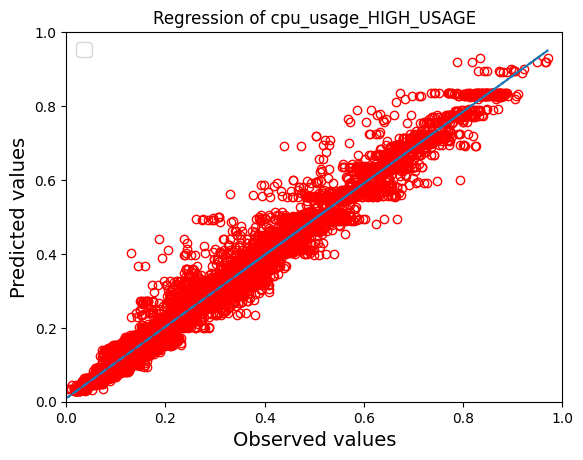

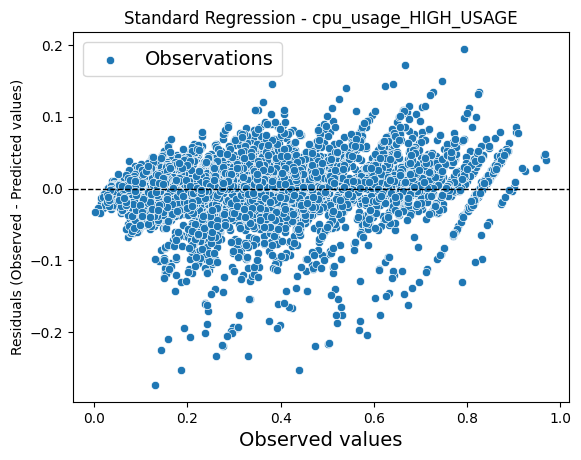

mape: 0.09763616152769516
mse: 156.51372400860978
rmse: 12.51054451287432
R-squared score: 0.9704255343508708
Standard deviation: 71.5984249579703
------------------------------
Target: cpu_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.874942739349518 % of cases and less or equal in 94.12505726065048 % of cases.
mape: 0.186697399111142
mse: 0.00609278585308118
rmse: 0.0780562992530467
R-squared score: 0.8470341359046475
Standard deviation: 0.1697714534072869
Quantile loss with library:  0.0032861438308707867
Prediction for alpha 0.95 are greater than true values in 95.01832340815392 % of cases and less or equal in 4.9816765918460835 % of cases.
mape: 0.23911867973048465
mse: 0.0032426091495382676
rmse: 0.056943912313242646
R-squared score: 0.9185908511404876
Standard deviation: 0.2054713548943207
Quantile loss with library:  0.002459129092958471


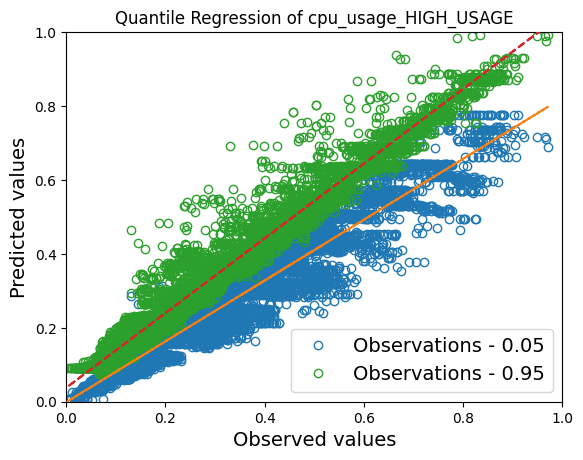

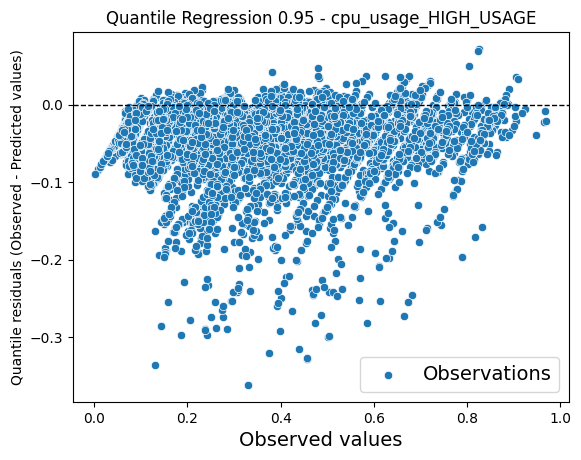

mape: 0.2087263472461471
mse: 430.83277336402887
rmse: 20.756511589475455
R-squared score: 0.9185908511404876
Standard deviation: 74.89595262981905
Quantile loss with library:  0.8963722274161063
------------------------------
Target: ram_usage_HIGH_USAGE
mape: 35.99415551742157
mse: 0.02289996909989776
rmse: 0.15132735740736952
R-squared score: 0.3489313790356696
Standard deviation: 0.11023738948502848


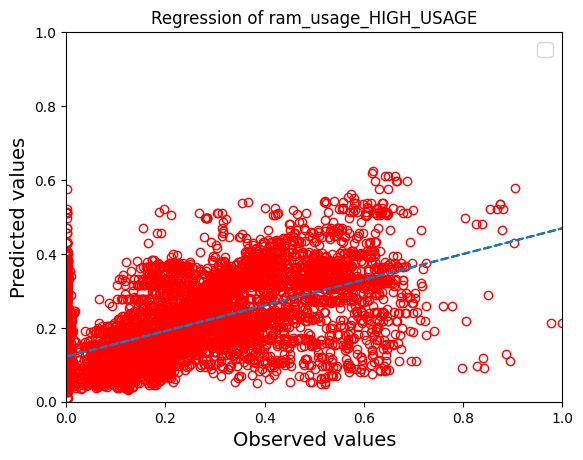

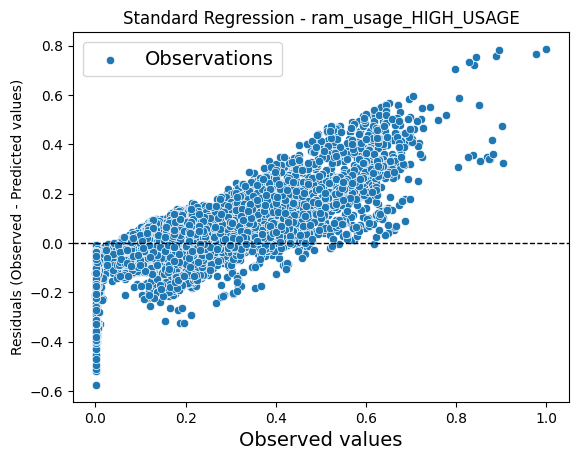

mape: 11.699756970383174
mse: 4596006142646277.0
rmse: 67793850.33058882
R-squared score: 0.34893137903566984
Standard deviation: 49385763.49724123
------------------------------
Target: ram_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.393953275309207 % of cases and less or equal in 94.6060467246908 % of cases.
mape: 0.8464061486555199
mse: 0.056953669185033855
rmse: 0.23864967878678123
R-squared score: -0.6192487724939431
Standard deviation: 0.06537626257518121
Quantile loss with library:  0.008352285239441854
Prediction for alpha 0.95 are greater than true values in 94.09070087036189 % of cases and less or equal in 5.9092991296381125 % of cases.
mape: 112.25952687813088
mse: 0.0858123265850492
rmse: 0.29293741069561124
R-squared score: -1.4397287563029146
Standard deviation: 0.18177450811679155
Quantile loss with library:  0.01218100465321318


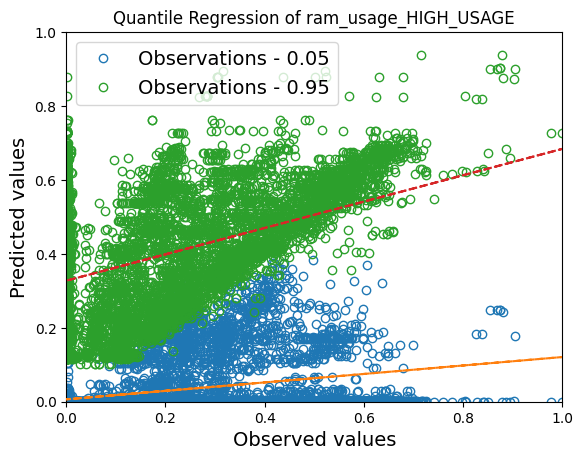

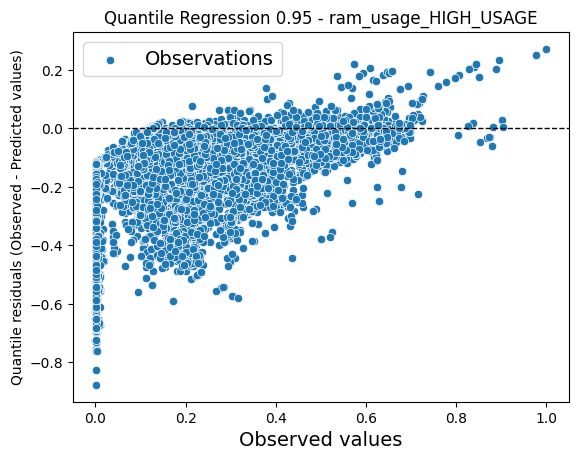

mape: 35.320626694956864
mse: 1.7222467784963754e+16
rmse: 131234400.15850933
R-squared score: -1.4397287563029137
Standard deviation: 81434011.72342178
Quantile loss with library:  5457025.223225926
------------------------------
Target: power_usage_HIGH_USAGE
mape: 0.12470661184420723
mse: 0.0011620761640317567
rmse: 0.034089238243641594
R-squared score: 0.9635445705704544
Standard deviation: 0.17517197733968498


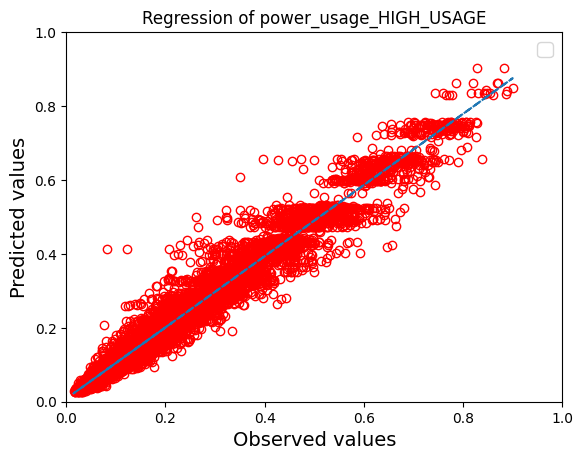

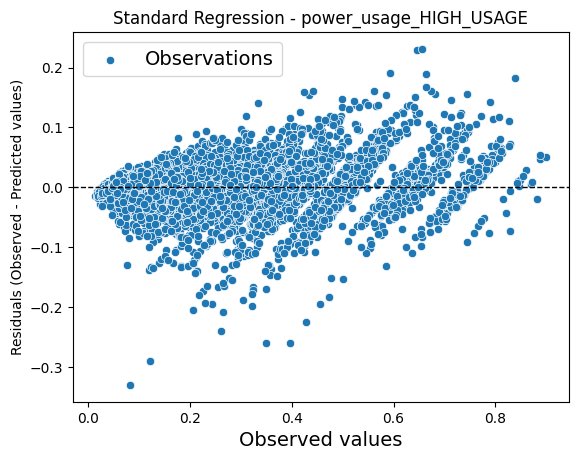

mape: 0.12360849496605418
mse: 4015676.450429744
rmse: 2003.915280252572
R-squared score: 0.9635445705704544
Standard deviation: 10297.378884039068
------------------------------
Target: power_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.16491067338525 % of cases and less or equal in 94.83508932661475 % of cases.
mape: 0.22392312643485057
mse: 0.004947586273541741
rmse: 0.07033908069872495
R-squared score: 0.8447895346068209
Standard deviation: 0.1459379083750861
Quantile loss with library:  0.0030792499483292364
Prediction for alpha 0.95 are greater than true values in 94.5716903344022 % of cases and less or equal in 5.428309665597801 % of cases.
mape: 0.2799876549271154
mse: 0.0039543241736330744
rmse: 0.06288341731834454
R-squared score: 0.8759491070247206
Standard deviation: 0.19636878859365367
Quantile loss with library:  0.002946660578527403


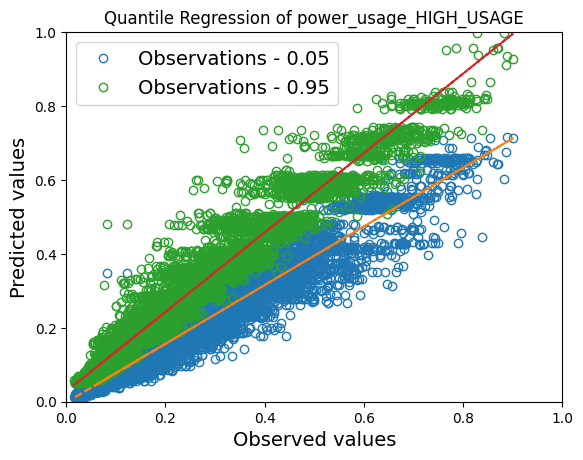

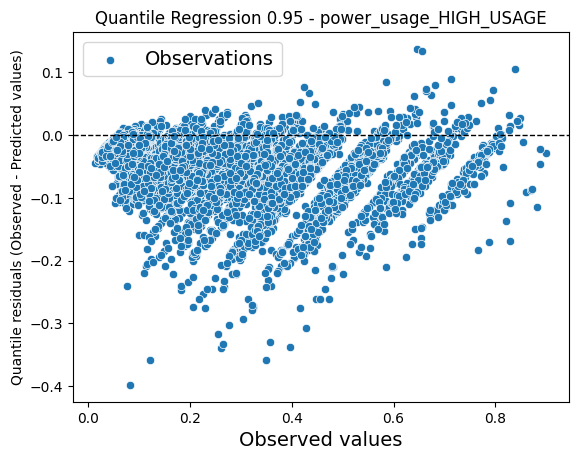

mape: 0.2773368690111838
mse: 13664583.22863376
rmse: 3696.5637054748236
R-squared score: 0.8759491070247206
Standard deviation: 11543.42063072962
Quantile loss with library:  173.21766232574396
------------------------------
Target: medium_latency_HIGH_USAGE
mape: 0.7930641212761275
mse: 0.006292024055181159
rmse: 0.07932227968976409
R-squared score: 0.9100657052106689
Standard deviation: 0.2502288495044242


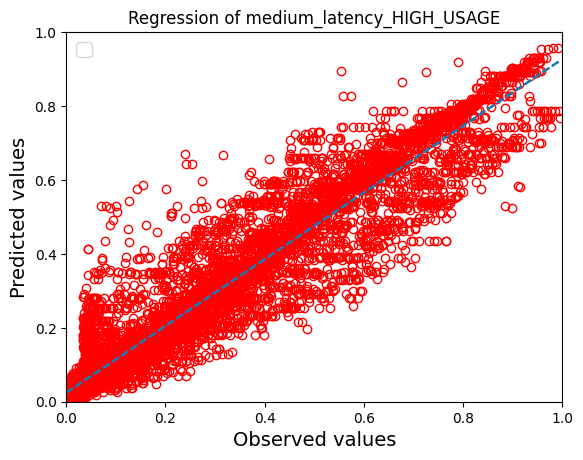

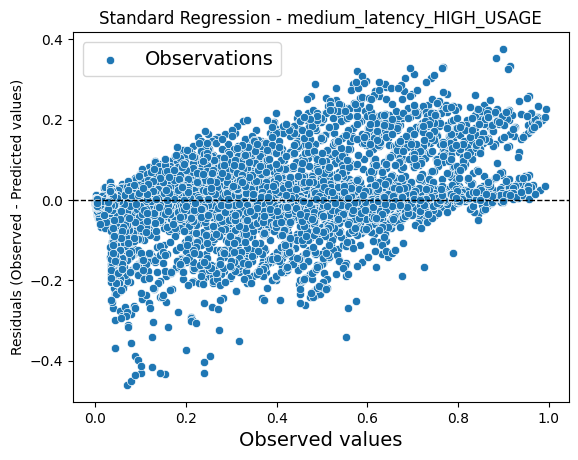

mape: 0.4955834876011407
mse: 5.461803351212438e+18
rmse: 2337050138.7887335
R-squared score: 0.9100657052106689
Standard deviation: 7372422599.935983
------------------------------
Target: medium_latency_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 4.741181859825928 % of cases and less or equal in 95.25881814017407 % of cases.
mape: 0.4757657697006206
mse: 0.033086260507090924
rmse: 0.18189629052592282
R-squared score: 0.5270854847620818
Standard deviation: 0.17756399121174646
Quantile loss with library:  0.006366694129804199
Prediction for alpha 0.95 are greater than true values in 95.15574896930829 % of cases and less or equal in 4.844251030691709 % of cases.
mape: 3.9806146091167696
mse: 0.021837742719474373
rmse: 0.1477759883048473
R-squared score: 0.6878648310872946
Standard deviation: 0.2831389837767017
Quantile loss with library:  0.0057352088920247304


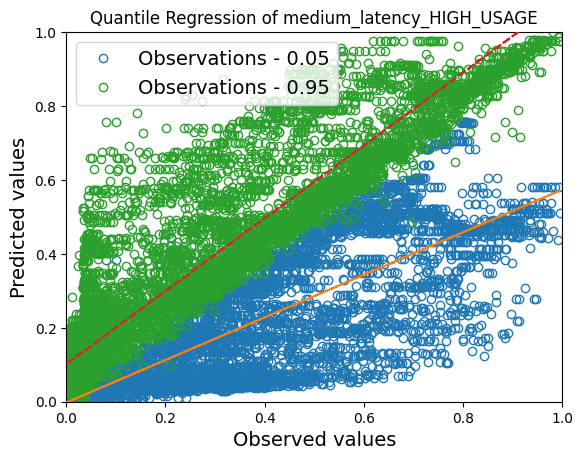

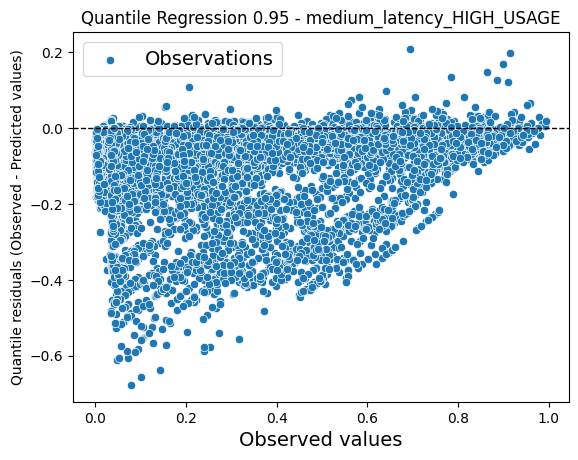

mape: 2.0059669797224333
mse: 1.8956293765266928e+19
rmse: 4353882608.117372
R-squared score: 0.6878648310872946
Standard deviation: 8342044680.508976
Quantile loss with library:  168974855.35603416
------------------------------
Target: cpu_usage_LOW_USAGE
mape: 0.1143336367444932
mse: 0.0009788753004563563
rmse: 0.031286982923515595
R-squared score: 0.9732779871832891
Standard deviation: 0.1887165625094651


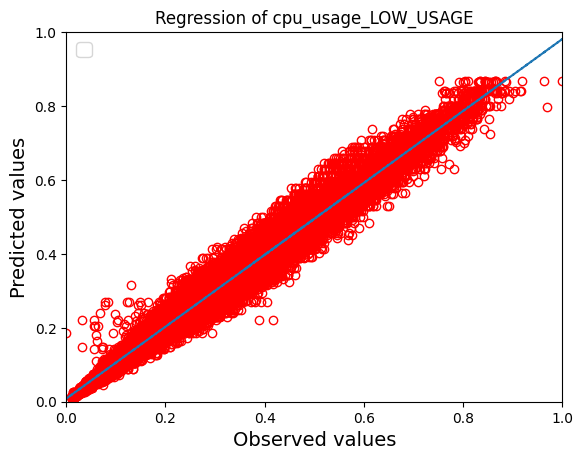

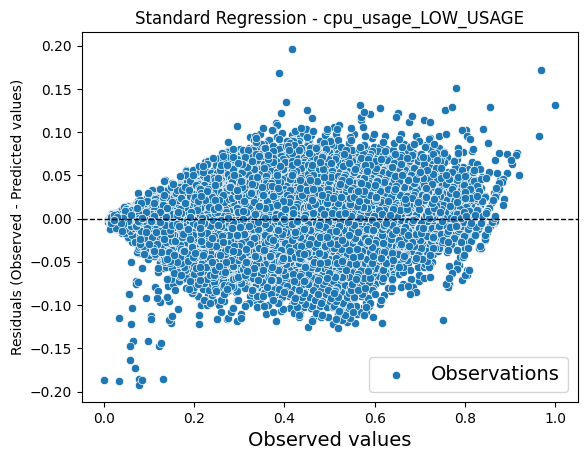

mape: 0.08747369327724003
mse: 4.179170230609863
rmse: 2.0443018932168173
R-squared score: 0.9732779871832891
Standard deviation: 12.330803099889291
------------------------------
Target: cpu_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 4.655844972945766 % of cases and less or equal in 95.34415502705423 % of cases.
mape: 0.16333026274762485
mse: 0.004148776310289486
rmse: 0.06441099525926831
R-squared score: 0.886743843995719
Standard deviation: 0.1638343635265753
Quantile loss with library:  0.0027664365092025228
Prediction for alpha 0.95 are greater than true values in 95.34415502705423 % of cases and less or equal in 4.655844972945766 % of cases.
mape: 0.3220031113769137
mse: 0.003539967606175002
rmse: 0.05949762689532249
R-squared score: 0.9033635237309089
Standard deviation: 0.2001582339335292
Quantile loss with library:  0.0027772569182037987


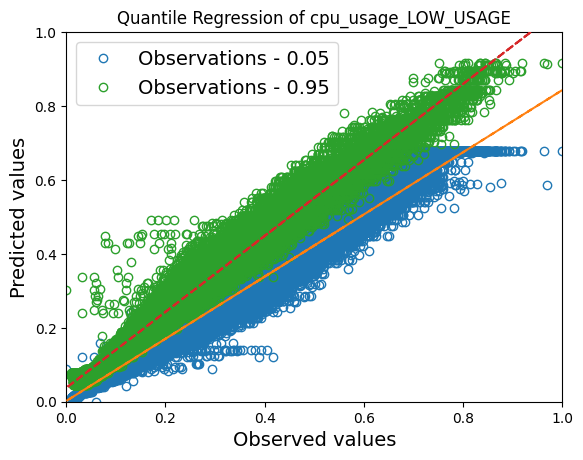

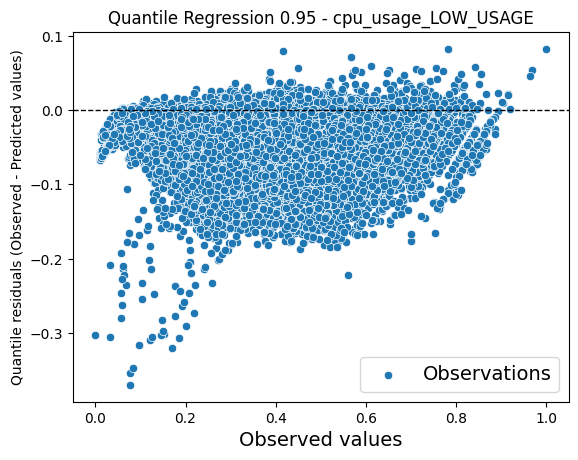

mape: 0.27275842122064414
mse: 15.113393125919856
rmse: 3.887594773882671
R-squared score: 0.9033635237309089
Standard deviation: 13.07840572462811
Quantile loss with library:  0.1814668927877423
------------------------------
Target: ram_usage_LOW_USAGE
mape: 5.796322778578413
mse: 0.007680598395370777
rmse: 0.08763902324518899
R-squared score: 0.5361072849815376
Standard deviation: 0.09388842559717933


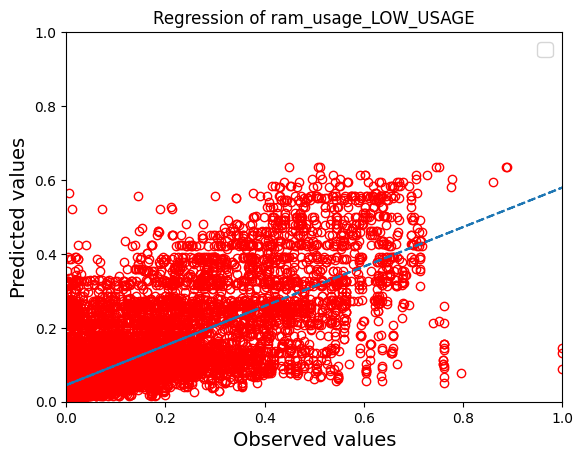

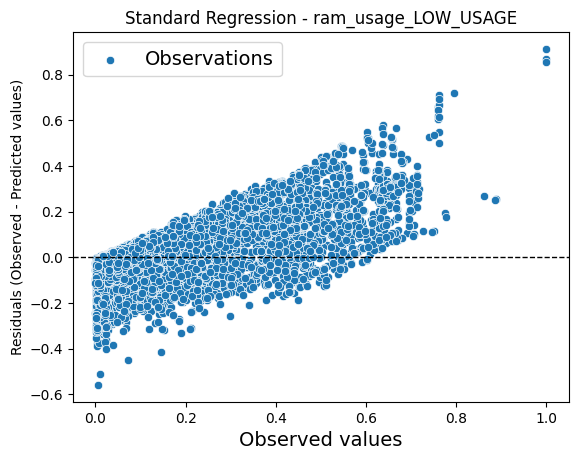

mape: 2.0576646515010544
mse: 1211484144740590.2
rmse: 34806380.804970086
R-squared score: 0.5361072849815376
Standard deviation: 37288369.64980574
------------------------------
Target: ram_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.268235392810705 % of cases and less or equal in 94.73176460718929 % of cases.
mape: 0.7901296531891455
mse: 0.019016600473363707
rmse: 0.1379006906196039
R-squared score: -0.14856446983701543
Standard deviation: 0.04439483824392351
Quantile loss with library:  0.0043659283740230224
Prediction for alpha 0.95 are greater than true values in 94.76532024663396 % of cases and less or equal in 5.234679753366049 % of cases.
mape: 15.989113829039626
mse: 0.03171139891091513
rmse: 0.17807694660150464
R-squared score: -0.915304795350881
Standard deviation: 0.1655638094672049
Quantile loss with library:  0.009617381859329966


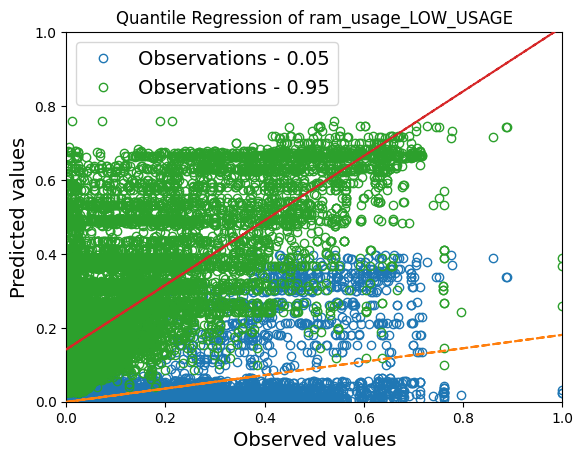

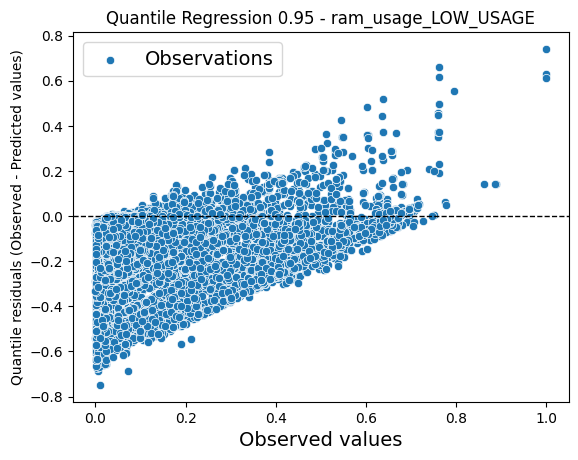

mape: 6.042541997483592
mse: 5001935397543083.0
rmse: 70724362.12185362
R-squared score: -0.9153047953508806
Standard deviation: 65754692.21872451
Quantile loss with library:  3819602.7630993277
------------------------------
Target: power_usage_LOW_USAGE
mape: 3.7015185911467356
mse: 0.001910153324864176
rmse: 0.04370530087831653
R-squared score: 0.934850582780989
Standard deviation: 0.16474636457507405


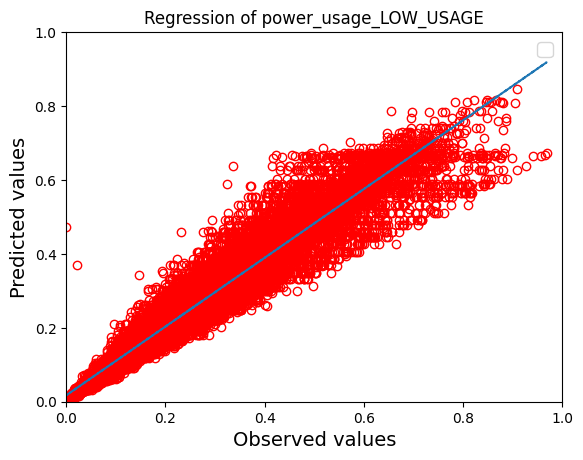

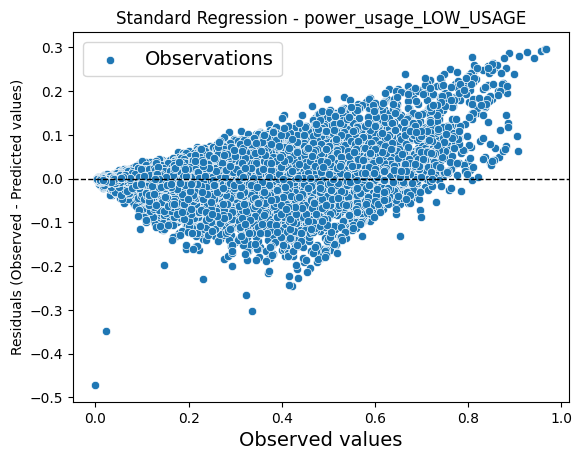

mape: 0.1399444790989909
mse: 44855251.65527458
rmse: 6697.406337924747
R-squared score: 0.934850582780989
Standard deviation: 25245.75564248266
------------------------------
Target: power_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.398263495658739 % of cases and less or equal in 94.60173650434126 % of cases.
mape: 3.2141996919540414
mse: 0.006548491066769223
rmse: 0.08092274752360565
R-squared score: 0.7766512399237634
Standard deviation: 0.1289031892638057
Quantile loss with library:  0.0034126862341587556
Prediction for alpha 0.95 are greater than true values in 95.0966821861499 % of cases and less or equal in 4.90331781385009 % of cases.
mape: 4.37702862123491
mse: 0.008477371886608255
rmse: 0.09207264461613045
R-squared score: 0.7108630858202823
Standard deviation: 0.2083352135255077
Quantile loss with library:  0.0039722157661793885


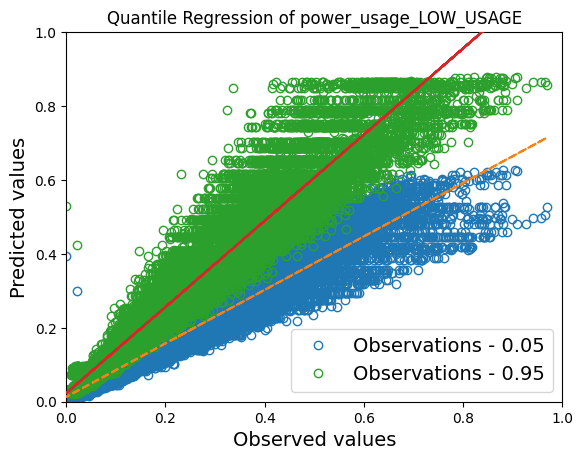

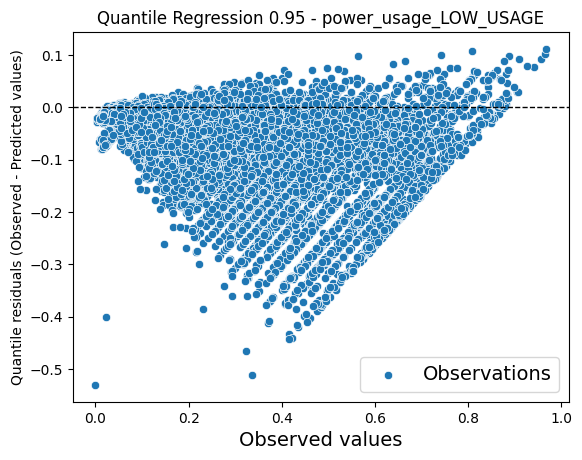

mape: 0.362971702280949
mse: 199070223.52574843
rmse: 14109.224767000787
R-squared score: 0.7108630858202823
Standard deviation: 31925.31687090827
Quantile loss with library:  608.7028921751053
------------------------------
Target: medium_latency_LOW_USAGE
mape: 1.7234830317968457
mse: 0.0004139545210533622
rmse: 0.020345872334539068
R-squared score: 0.753383376679254
Standard deviation: 0.03532201848435261


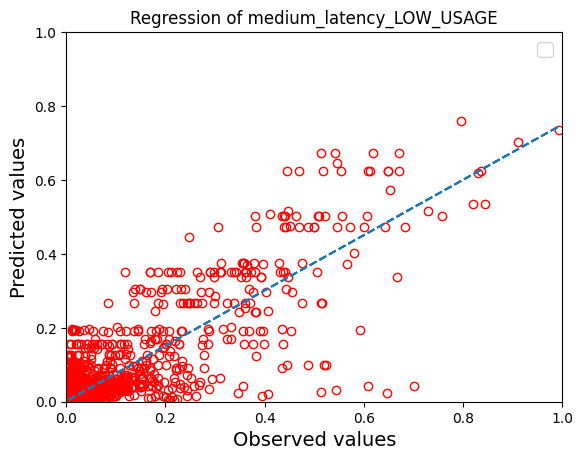

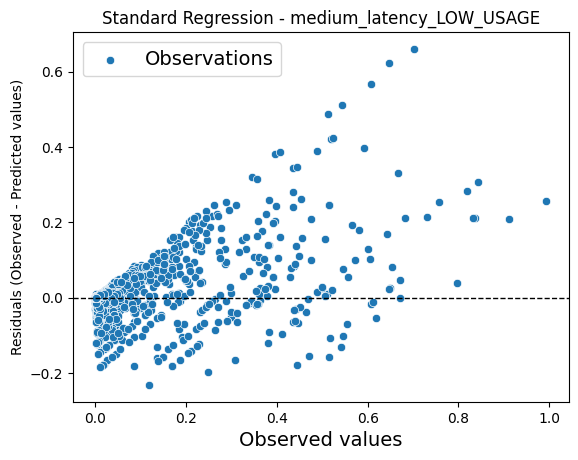

mape: 1.1485443335450654
mse: 1.5068319320008285e+17
rmse: 388179331.23761606
R-squared score: 0.753383376679254
Standard deviation: 673909542.3272908
------------------------------
Target: medium_latency_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.318568851977686 % of cases and less or equal in 94.68143114802231 % of cases.
mape: 0.44663541031343523
mse: 0.001577196080208366
rmse: 0.03971392803801163
R-squared score: 0.060373176681495555
Standard deviation: 0.002792760565268039
Quantile loss with library:  0.00030919830994242026
Prediction for alpha 0.95 are greater than true values in 94.95407071851012 % of cases and less or equal in 5.045929281489871 % of cases.
mape: 5.8505117116152
mse: 0.0014285194108373833
rmse: 0.037795759164718244
R-squared score: 0.14894845802772883
Standard deviation: 0.059959867840350886
Quantile loss with library:  0.0010444553735042446


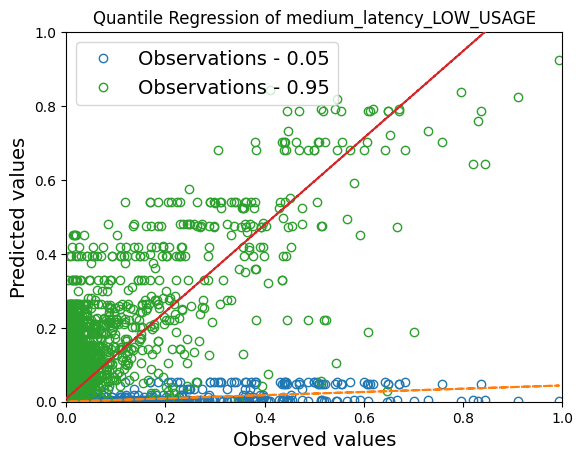

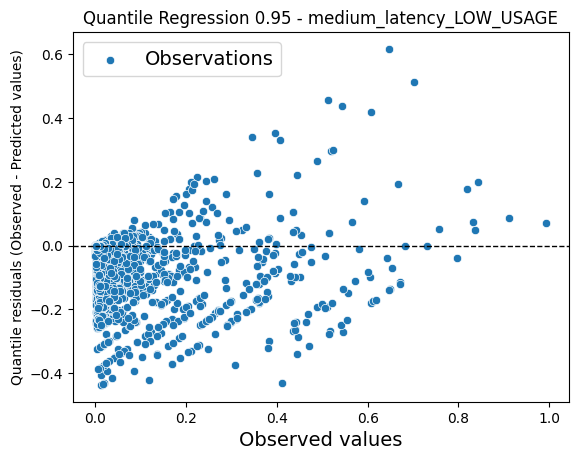

mape: 3.8799479081515686
mse: 5.1999399795305043e+17
rmse: 721106093.4100131
R-squared score: 0.14894845802772871
Standard deviation: 1143975594.4920287
Quantile loss with library:  19927186.297445986
------------------------------
Target: cpu_usage_MEDIUM_USAGE
mape: 31106455208.045498
mse: 0.0004928224888048741
rmse: 0.022199605600209976
R-squared score: 0.9867347289398967
Standard deviation: 0.19132985138977923


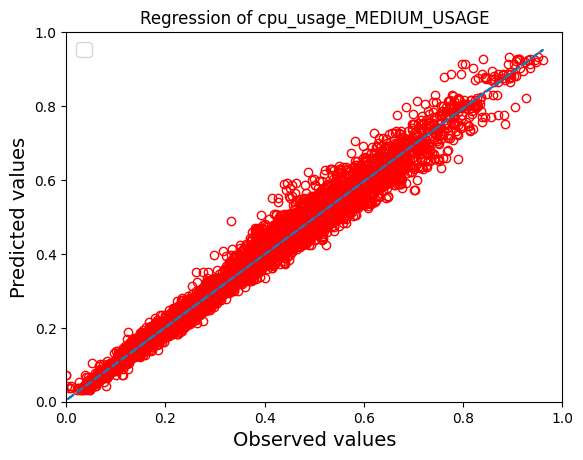

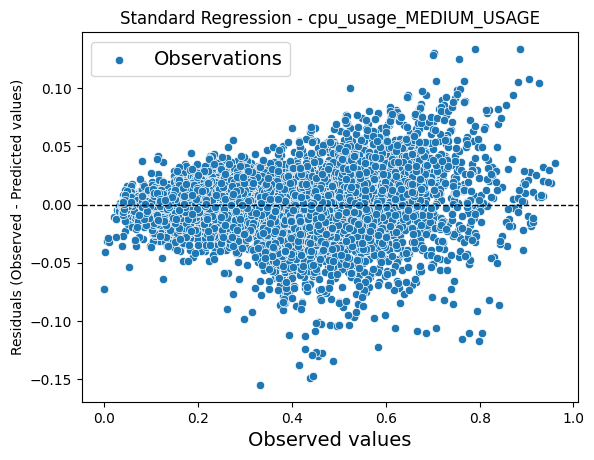

mape: 0.11006759859352988
mse: 8.239757634326978
rmse: 2.8704978025295502
R-squared score: 0.9867347289398967
Standard deviation: 24.73971510410401
------------------------------
Target: cpu_usage_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 4.797572769507917 % of cases and less or equal in 95.20242723049208 % of cases.
mape: 11201749351.428268
mse: 0.0036808917577236884
rmse: 0.06067035320256252
R-squared score: 0.9009216746023174
Standard deviation: 0.15918803045305754
Quantile loss with library:  0.0023083174100310177
Prediction for alpha 0.95 are greater than true values in 95.76182800796434 % of cases and less or equal in 4.2381719920356495 % of cases.
mape: 55394082490.64399
mse: 0.002110692628992757
rmse: 0.045942274965360144
R-squared score: 0.9431866230048668
Standard deviation: 0.20416661081611562
Quantile loss with library:  0.0020602280228788667


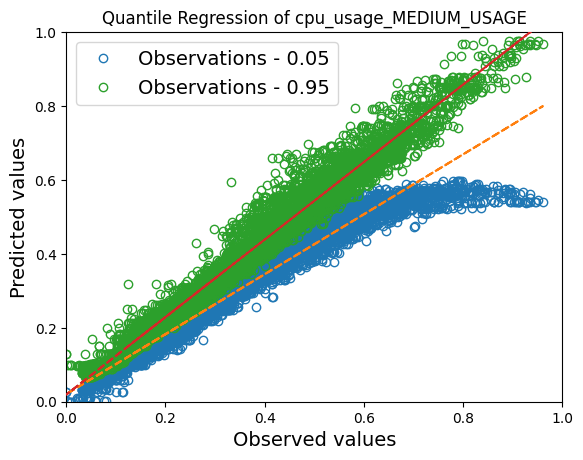

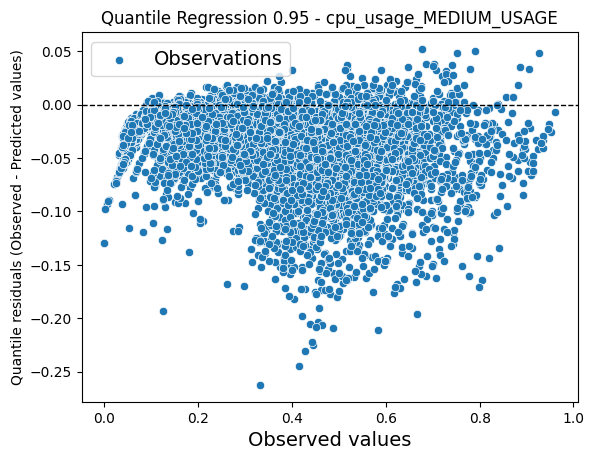

mape: 0.2930969740459273
mse: 35.28977694511563
rmse: 5.940519922120927
R-squared score: 0.9431866230048668
Standard deviation: 26.39955944496701
Quantile loss with library:  0.26639572427032904
------------------------------
Target: ram_usage_MEDIUM_USAGE
mape: 28.92749261498035
mse: 0.053152923279545544
rmse: 0.23054917757291077
R-squared score: 0.2847471010979964
Standard deviation: 0.14043828454940674


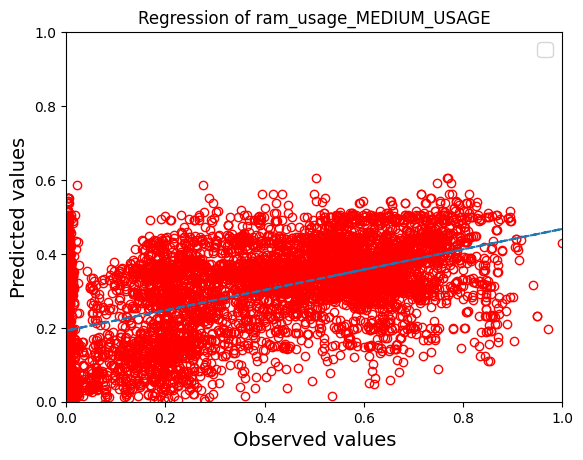

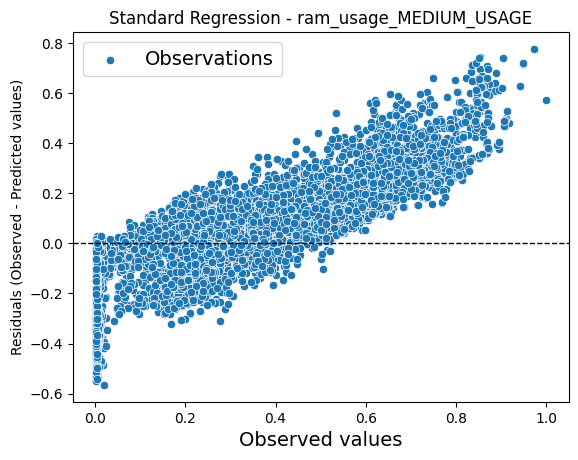

mape: 13.92452323727697
mse: 4430281319123485.0
rmse: 66560358.466008015
R-squared score: 0.2847471010979963
Standard deviation: 40545026.70695313
------------------------------
Target: ram_usage_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.622451882051768 % of cases and less or equal in 94.37754811794822 % of cases.
mape: 0.7016226177798222
mse: 0.14153925301713108
rmse: 0.3762170291429284
R-squared score: -0.9046245207718466
Standard deviation: 0.016118940764018114
Quantile loss with library:  0.013125616938914826
Prediction for alpha 0.95 are greater than true values in 94.9179861572011 % of cases and less or equal in 5.0820138427989 % of cases.
mape: 77.7703862304502
mse: 0.16197600889760222
rmse: 0.40246243165990314
R-squared score: -1.179631951892473
Standard deviation: 0.19810055613101563
Quantile loss with library:  0.017240226984098418


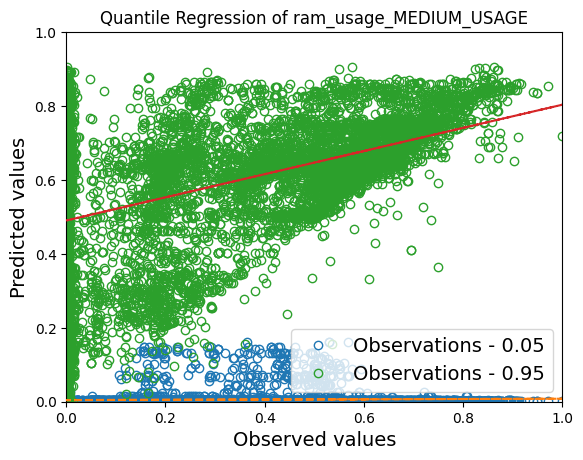

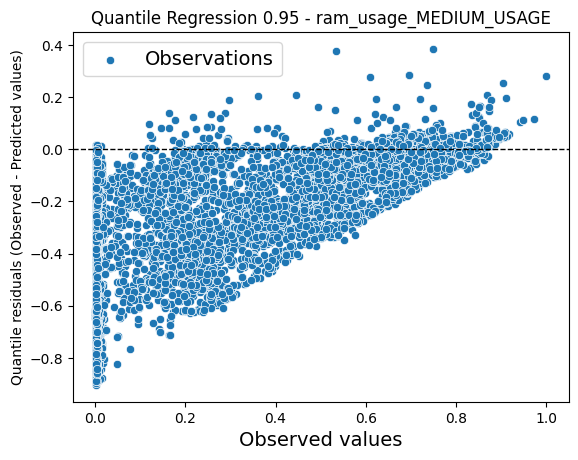

mape: 36.834463605337106
mse: 1.3500655130314816e+16
rmse: 116192319.58401905
R-squared score: -1.179631951892473
Standard deviation: 57192327.325591974
Quantile loss with library:  4977314.168618254
------------------------------
Target: power_usage_MEDIUM_USAGE
mape: 0.12121945072992583
mse: 0.001389563999755565
rmse: 0.037276856087330716
R-squared score: 0.9444303592771742
Standard deviation: 0.1531379777244658


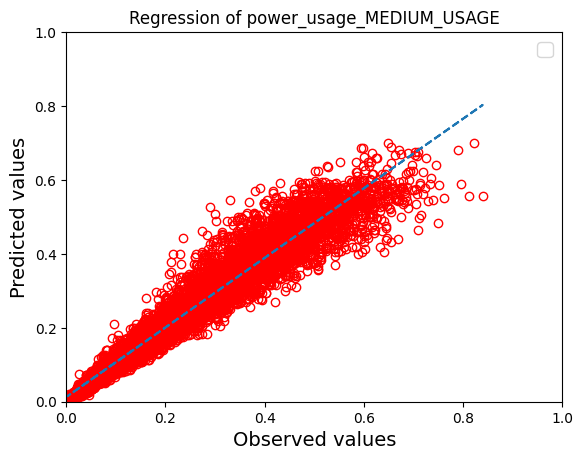

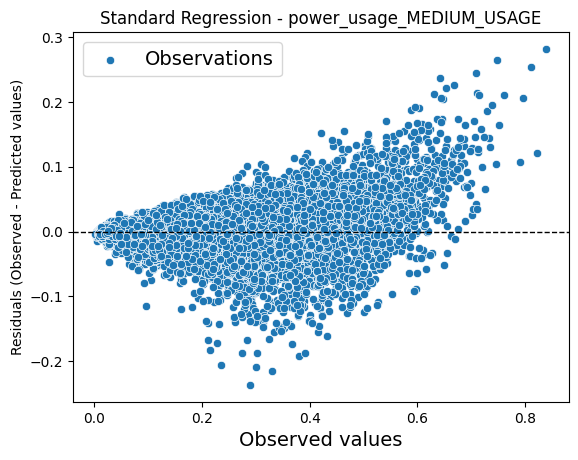

mape: 0.10945962670271284
mse: 22974688.6388154
rmse: 4793.191905068626
R-squared score: 0.9444303592771742
Standard deviation: 19691.03063487589
------------------------------
Target: power_usage_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.612970512942069 % of cases and less or equal in 94.38702948705793 % of cases.
mape: 0.2153268536060744
mse: 0.004961455617939065
rmse: 0.07043760088148279
R-squared score: 0.8015879036880502
Standard deviation: 0.12065103147979384
Quantile loss with library:  0.003020082923383029
Prediction for alpha 0.95 are greater than true values in 94.25429031952214 % of cases and less or equal in 5.745709680477861 % of cases.
mape: 0.3066185112417132
mse: 0.004918308720523662
rmse: 0.07013065464205837
R-squared score: 0.8033133784327187
Standard deviation: 0.18352876510304283
Quantile loss with library:  0.003431220764605003


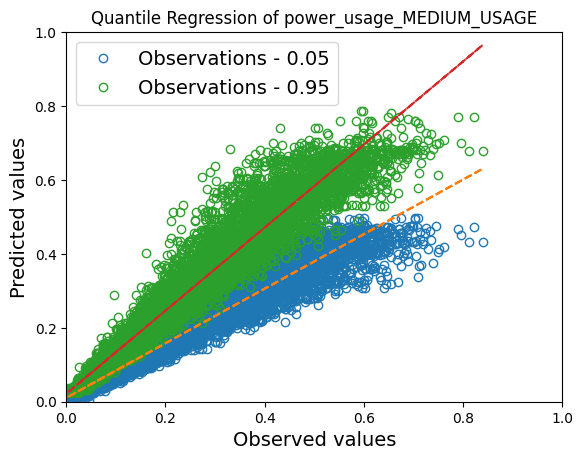

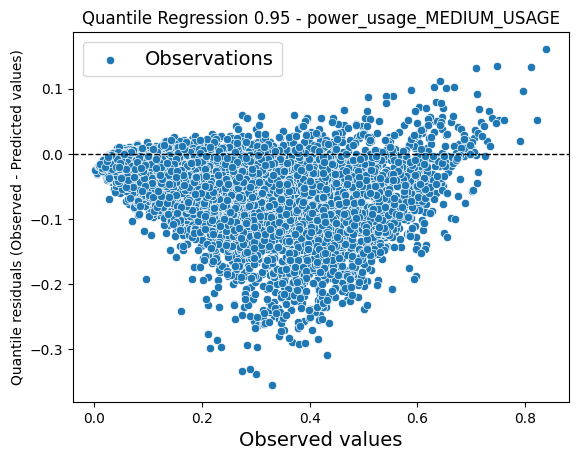

mape: 0.2662408124178322
mse: 81318033.21292049
rmse: 9017.651202664721
R-squared score: 0.8033133784327187
Standard deviation: 23598.78711815844
Quantile loss with library:  441.1986771330147
------------------------------
Target: medium_latency_MEDIUM_USAGE
mape: 2212809828.2329726
mse: 0.0008541564917515251
rmse: 0.029225955788502882
R-squared score: 0.9837967156223113
Standard deviation: 0.22745744167064041


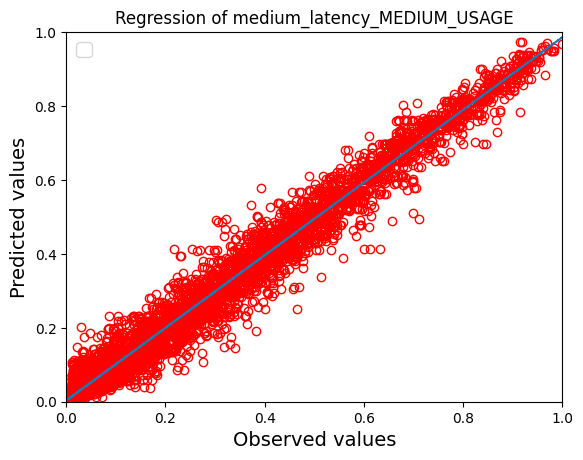

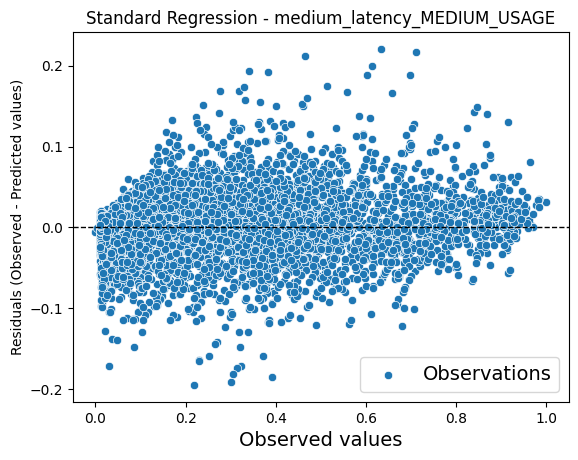

mape: 0.2238185265452554
mse: 6.675117853272755e+17
rmse: 817013944.3897365
R-squared score: 0.9837967156223113
Standard deviation: 6358591073.802756
------------------------------
Target: medium_latency_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 4.939793306153409 % of cases and less or equal in 95.0602066938466 % of cases.
mape: 287168774.4881381
mse: 0.013019237480647077
rmse: 0.11410187325652053
R-squared score: 0.7530260446220969
Standard deviation: 0.15152287590855723
Quantile loss with library:  0.0030484222020205677
Prediction for alpha 0.95 are greater than true values in 96.10315729591353 % of cases and less or equal in 3.89684270408647 % of cases.
mape: 6178518896.010564
mse: 0.007077958980860997
rmse: 0.08413060668306747
R-squared score: 0.8657316507127029
Standard deviation: 0.24467104905808715
Quantile loss with library:  0.0031142904564094476


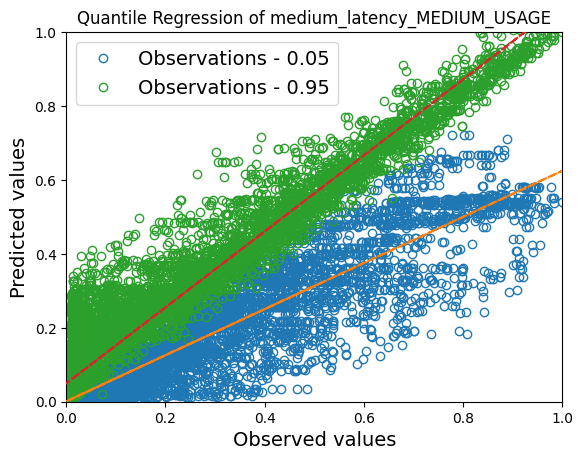

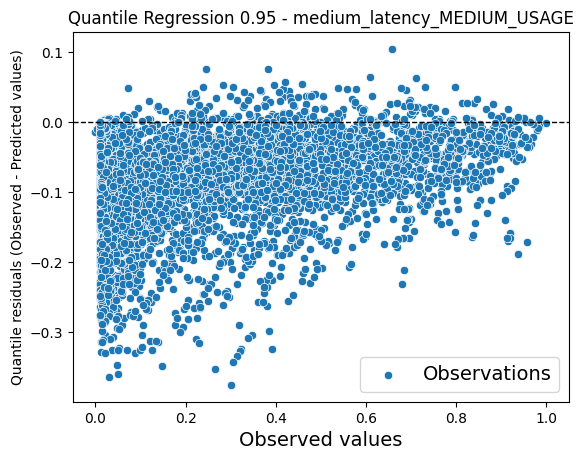

mape: 1.3856987297897738
mse: 5.531329541381212e+18
rmse: 2351877875.52441
R-squared score: 0.8657316507127029
Standard deviation: 6839798852.61992
Quantile loss with library:  87060240.15705033
------------------------------
Target: cpu_usage_node
mape: 0.06697205746084144
mse: 0.0008461424277825379
rmse: 0.02908852742547374
R-squared score: 0.9753661980406773
Standard deviation: 0.18263261138785727


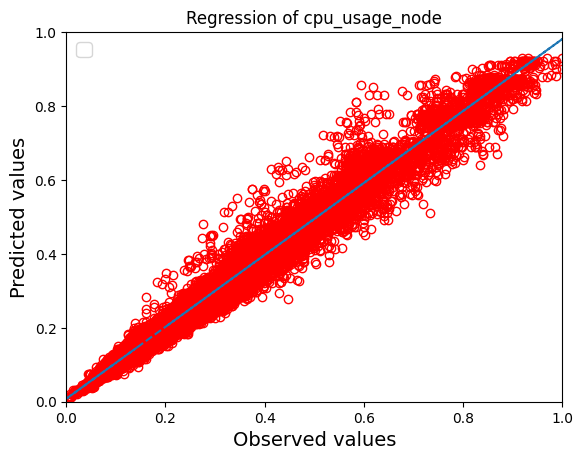

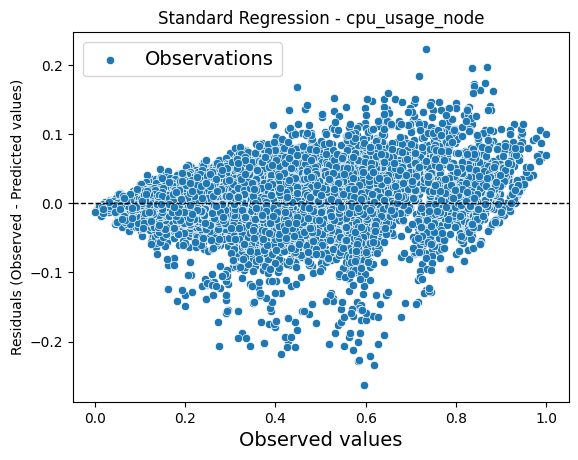

mape: 0.04008430811480892
mse: 144.21549341375635
rmse: 12.008975535563238
R-squared score: 0.9753661980406773
Standard deviation: 75.3984734281229
------------------------------
Target: cpu_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 4.8575942956690845 % of cases and less or equal in 95.14240570433091 % of cases.
mape: 0.1362055411712325
mse: 0.005108548904586699
rmse: 0.07147411352781298
R-squared score: 0.8512744688327506
Standard deviation: 0.14642900317842045
Quantile loss with library:  0.0027254996567016763
Prediction for alpha 0.95 are greater than true values in 95.09378924766033 % of cases and less or equal in 4.906210752339667 % of cases.
mape: 0.20457019472999532
mse: 0.0033833891376177333
rmse: 0.05816690758169746
R-squared score: 0.9014991622795456
Standard deviation: 0.19758189146600755
Quantile loss with library:  0.002834687416851703


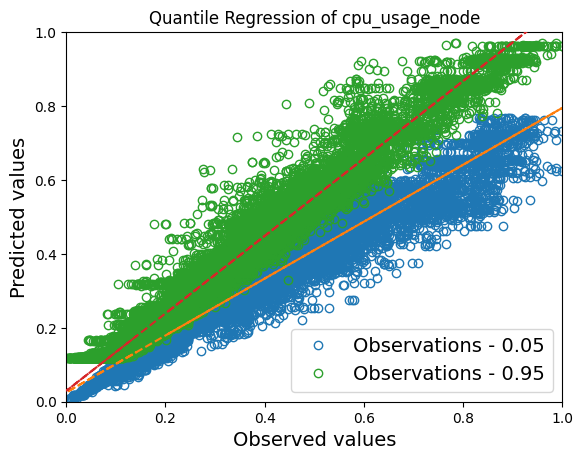

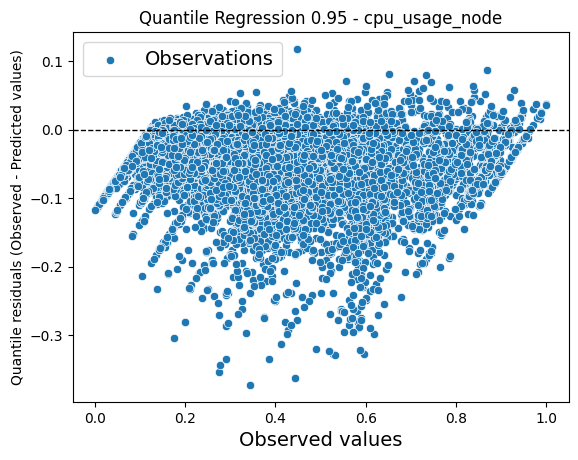

mape: 0.1042077142927709
mse: 576.6607581314751
rmse: 24.01376184881234
R-squared score: 0.9014991622795456
Standard deviation: 81.57016909723997
Quantile loss with library:  1.1702789674436964
------------------------------
Target: ram_usage_node
mape: 0.09984261690831056
mse: 0.004272396112940356
rmse: 0.06536356869801675
R-squared score: 0.7617648843286382
Standard deviation: 0.11692126491005217


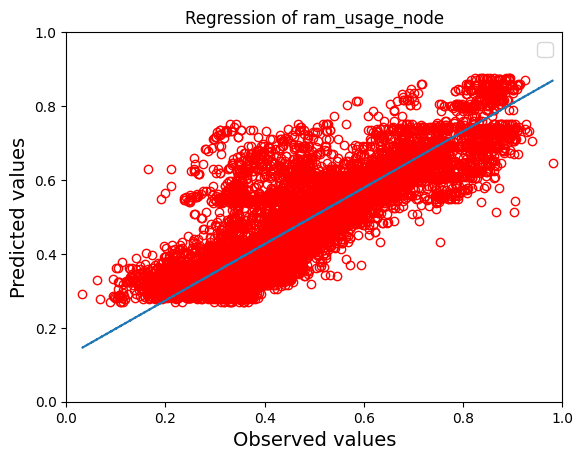

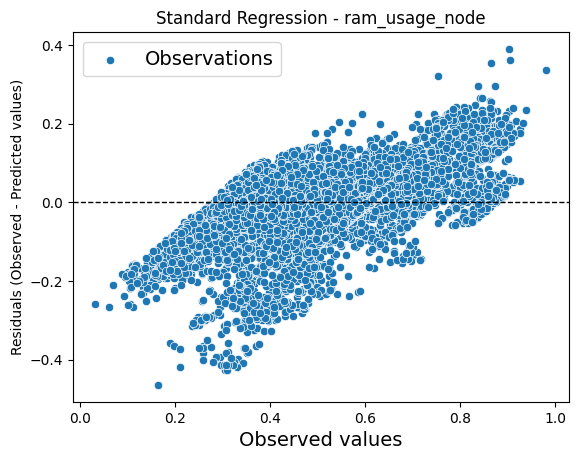

mape: 0.033084455276283425
mse: 4.678821084381958e+16
rmse: 216305827.11480424
R-squared score: 0.7617648843286382
Standard deviation: 386924267.1024071
------------------------------
Target: ram_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.11688206457886 % of cases and less or equal in 94.88311793542114 % of cases.
mape: 0.2225222268099222
mse: 0.022480734254149096
rmse: 0.1499357670942764
R-squared score: -0.2535589359780699
Standard deviation: 0.11843890512918165
Quantile loss with library:  0.006907260038911067
Prediction for alpha 0.95 are greater than true values in 94.91147753514565 % of cases and less or equal in 5.0885224648543534 % of cases.
mape: 0.1753261560848459
mse: 0.010250368205712544
rmse: 0.10124410207865218
R-squared score: 0.42842433365071564
Standard deviation: 0.12470187076528598
Quantile loss with library:  0.004467814646384309


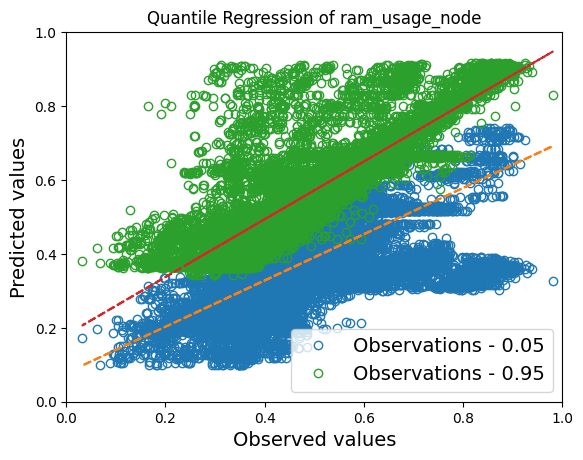

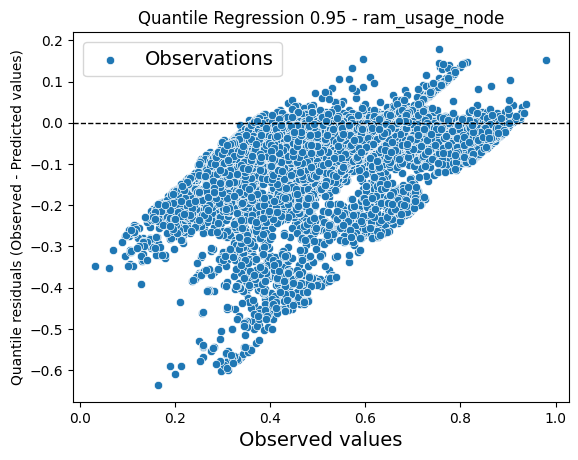

mape: 0.057034385911072176
mse: 1.1225466369633838e+17
rmse: 335044271.2483507
R-squared score: 0.42842433365071564
Standard deviation: 412672408.1310303
Quantile loss with library:  14785213.869620271
------------------------------
Target: power_usage_node
mape: 0.14091200550990238
mse: 0.0015903597567446064
rmse: 0.03987931489813493
R-squared score: 0.9270590988572881
Standard deviation: 0.14172042324517645


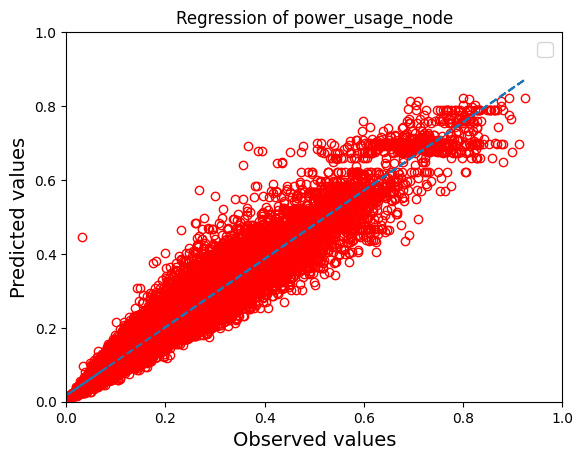

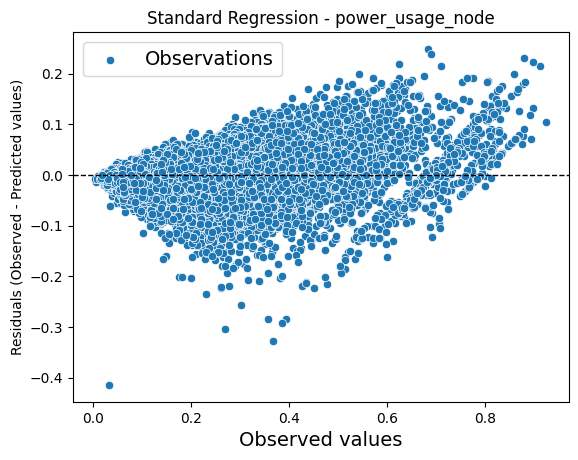

mape: 0.11027204558020859
mse: 25030831323.111965
rmse: 158211.3501715726
R-squared score: 0.9270590988572881
Standard deviation: 562240.8400389724
------------------------------
Target: power_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.315399262650407 % of cases and less or equal in 94.68460073734958 % of cases.
mape: 0.23974303182595777
mse: 0.005896326614297558
rmse: 0.07678754205141325
R-squared score: 0.7295684986653708
Standard deviation: 0.11322463262579607
Quantile loss with library:  0.003412914843374318
Prediction for alpha 0.95 are greater than true values in 94.8709638212535 % of cases and less or equal in 5.129036178746506 % of cases.
mape: 0.33622195504448277
mse: 0.005736639375752282
rmse: 0.07574060585810152
R-squared score: 0.736892458562549
Standard deviation: 0.16614532649877942
Quantile loss with library:  0.0035689131804975908


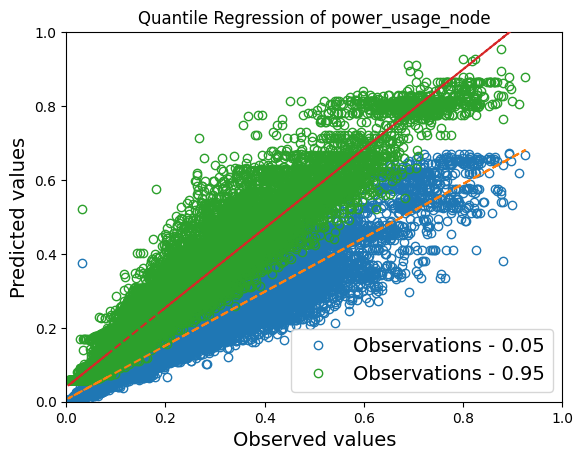

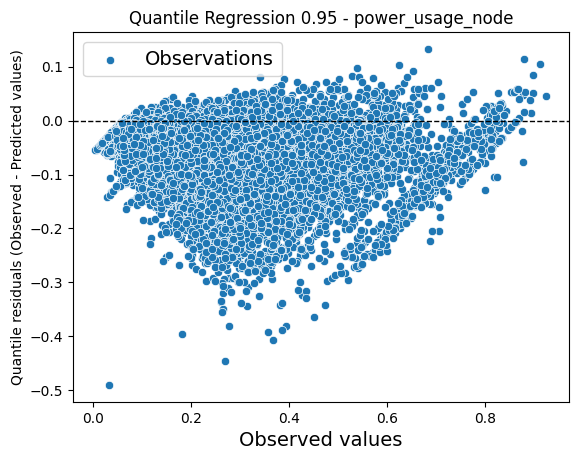

mape: 0.24946741133481903
mse: 90289541072.0815
rmse: 300482.1809560119
R-squared score: 0.7368924585625491
Standard deviation: 659140.6220796936
Quantile loss with library:  14158.783178044327
------------------------------
Target: overloaded_node
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     22700
           1       0.96      0.99      0.98     22670

    accuracy                           0.98     45370
   macro avg       0.98      0.98      0.98     45370
weighted avg       0.98      0.98      0.98     45370

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     22700
         1.0       0.96      0.99      0.98     22670

    accuracy                           0.98     45370
   macro avg       0.98      0.98      0.98     45370
weighted avg       0.98      0.98      0.98     45370

------------------------------


In [392]:
all_metrics, all_metrics_no_scale = compute_metrics_and_plot(all_predictions, y_test_dict, y_scalers)

In [393]:
os.makedirs("output/metrics/groups", exist_ok = True)
all_metrics.to_csv("output/metrics/groups/all_metrics.csv")
all_metrics

mape       mse      rmse  \
cpu_usage_HIGH_USAGE                              0.10837  0.001178  0.034322   
cpu_usage_HIGH_USAGE quantiles                   0.239119  0.003243  0.056944   
cpu_usage_LOW_USAGE                              0.114334  0.000979  0.031287   
cpu_usage_LOW_USAGE quantiles                    0.322003   0.00354  0.059498   
cpu_usage_MEDIUM_USAGE                 31106455208.045498  0.000493    0.0222   
cpu_usage_MEDIUM_USAGE quantiles        55394082490.64399  0.002111  0.045942   
cpu_usage_node                                   0.066972  0.000846  0.029089   
cpu_usage_node quantiles                          0.20457  0.003383  0.058167   
medium_latency_HIGH_USAGE                        0.793064  0.006292  0.079322   
medium_latency_HIGH_USAGE quantiles              3.980615  0.021838  0.147776   
medium_latency_LOW_USAGE                         1.723483  0.000414  0.020346   
medium_latency_LOW_USAGE quantiles               5.850512  0.001429  0.037796   
medium_latency_MEDIUM_USAGE             2212809828.232973  0.000854  0.029226   
medium_latency_MEDIUM_USAGE quantiles   6178518896.010564  0.007078  0.084131   
overloaded_node                                       NaN       NaN       NaN   
power_usage_HIGH_USAGE                           0.124707  0.001162  0.034089   
power_usage_HIGH_USAGE quantiles                 0.279988  0.003954  0.062883   
power_usage_LOW_USAGE                            3.701519   0.00191  0.043705   
power_usage_LOW_USAGE quantiles                  4.377029  0.008477  0.092073   
power_usage_MEDIUM_USAGE                         0.121219   0.00139  0.037277   
power_usage_MEDIUM_USAGE quantiles               0.306619  0.004918  0.070131   
power_usage_node                                 0.140912   0.00159  0.039879   
power_usage_node quantiles                       0.336222  0.005737  0.075741   
ram_usage_HIGH_USAGE                            35.994156    0.0229  0.151327   
ram_usage_HIGH_USAGE quantiles                 112.259527  0.085812  0.292937   
ram_usage_LOW_USAGE                              5.796323  0.007681  0.087639   
ram_usage_LOW_USAGE quantiles                   15.989114  0.031711  0.178077   
ram_usage_MEDIUM_USAGE                          28.927493  0.053153  0.230549   
ram_usage_MEDIUM_USAGE quantiles                77.770386  0.161976  0.402462   
ram_usage_node                                   0.099843  0.004272  0.065364   
ram_usage_node quantiles                         0.175326   0.01025  0.101244   

                                             r2  \
cpu_usage_HIGH_USAGE                   0.970426   
cpu_usage_HIGH_USAGE quantiles         0.918591   
cpu_usage_LOW_USAGE                    0.973278   
cpu_usage_LOW_USAGE quantiles          0.903364   
cpu_usage_MEDIUM_USAGE                 0.986735   
cpu_usage_MEDIUM_USAGE quantiles       0.943187   
cpu_usage_node                         0.975366   
cpu_usage_node quantiles               0.901499   
medium_latency_HIGH_USAGE              0.910066   
medium_latency_HIGH_USAGE quantiles    0.687865   
medium_latency_LOW_USAGE               0.753383   
medium_latency_LOW_USAGE quantiles     0.148948   
medium_latency_MEDIUM_USAGE            0.983797   
medium_latency_MEDIUM_USAGE quantiles  0.865732   
overloaded_node                             NaN   
power_usage_HIGH_USAGE                 0.963545   
power_usage_HIGH_USAGE quantiles       0.875949   
power_usage_LOW_USAGE                  0.934851   
power_usage_LOW_USAGE quantiles        0.710863   
power_usage_MEDIUM_USAGE                0.94443   
power_usage_MEDIUM_USAGE quantiles     0.803313   
power_usage_node                       0.927059   
power_usage_node quantiles             0.736892   
ram_usage_HIGH_USAGE                   0.348931   
ram_usage_HIGH_USAGE quantiles        -1.439729   
ram_usage_LOW_USAGE                    0.536107   
ram_usage_LOW_USAGE quantiles         -0.915305   
ram_usage_MEDIUM_USAGE          

In [394]:
all_metrics_no_scale.to_csv("output/metrics/groups/all_metrics_no_scale.csv")
all_metrics_no_scale

mape                     mse  \
cpu_usage_HIGH_USAGE                    0.097636              156.513724   
cpu_usage_HIGH_USAGE quantiles          0.208726              430.832773   
cpu_usage_LOW_USAGE                     0.087474                 4.17917   
cpu_usage_LOW_USAGE quantiles           0.272758               15.113393   
cpu_usage_MEDIUM_USAGE                  0.110068                8.239758   
cpu_usage_MEDIUM_USAGE quantiles        0.293097               35.289777   
cpu_usage_node                          0.040084              144.215493   
cpu_usage_node quantiles                0.104208              576.660758   
medium_latency_HIGH_USAGE               0.495583   5461803351212437504.0   
medium_latency_HIGH_USAGE quantiles     2.005967  18956293765266927616.0   
medium_latency_LOW_USAGE                1.148544    150683193200082848.0   
medium_latency_LOW_USAGE quantiles      3.879948    519993997953050432.0   
medium_latency_MEDIUM_USAGE             0.223819    667511785327275520.0   
medium_latency_MEDIUM_USAGE quantiles   1.385699   5531329541381212160.0   
overloaded_node                              NaN                     NaN   
power_usage_HIGH_USAGE                  0.123608           4015676.45043   
power_usage_HIGH_USAGE quantiles        0.277337         13664583.228634   
power_usage_LOW_USAGE                   0.139944         44855251.655275   
power_usage_LOW_USAGE quantiles         0.362972        199070223.525748   
power_usage_MEDIUM_USAGE                 0.10946         22974688.638815   
power_usage_MEDIUM_USAGE quantiles      0.266241          81318033.21292   
power_usage_node                        0.110272      25030831323.111965   
power_usage_node quantiles              0.249467      90289541072.081497   
ram_usage_HIGH_USAGE                   11.699757      4596006142646277.0   
ram_usage_HIGH_USAGE quantiles         35.320627     17222467784963754.0   
ram_usage_LOW_USAGE                     2.057665     1211484144740590.25   
ram_usage_LOW_USAGE quantiles           6.042542      5001935397543083.0   
ram_usage_MEDIUM_USAGE                 13.924523      4430281319123485.0   
ram_usage_MEDIUM_USAGE quantiles       36.834464     13500655130314816.0   
ram_usage_node                          0.033084     46788210843819584.0   
ram_usage_node quantiles                0.057034    112254663696338384.0   

                                                    rmse        r2  \
cpu_usage_HIGH_USAGE                           12.510545  0.970426   
cpu_usage_HIGH_USAGE quantiles                 20.756512  0.918591   
cpu_usage_LOW_USAGE                             2.044302  0.973278   
cpu_usage_LOW_USAGE quantiles                   3.887595  0.903364   
cpu_usage_MEDIUM_USAGE                          2.870498  0.986735   
cpu_usage_MEDIUM_USAGE quantiles                 5.94052  0.943187   
cpu_usage_node                                 12.008976  0.975366   
cpu_usage_node quantiles                       24.013762  0.901499   
medium_latency_HIGH_USAGE              2337050138.788733  0.910066   
medium_latency_HIGH_USAGE quantiles    4353882608.117372  0.687865   
medium_latency_LOW_USAGE                388179331.237616  0.753383   
medium_latency_LOW_USAGE quantiles      721106093.410013  0.148948   
medium_latency_MEDIUM_USAGE             817013944.389737  0.983797   
medium_latency_MEDIUM_USAGE quantiles   2351877875.52441  0.865732   
overloaded_node                                      NaN       NaN   
power_usage_HIGH_USAGE                        2003.91528  0.963545   
power_usage_HIGH_USAGE quantiles             3696.563705  0.875949   
power_usage_LOW_USAGE                        6697.406338  0.934851   
power_usage_LOW_USAGE quantiles             14109.224767  0.710863   
power_usage_MEDIUM_USAGE                     4793.191905   0.94443   
power_usage_MEDIUM_USAGE quantiles           9017.651203  0.803313   
power_usage_node                           158211.350172  0.927059   
p

In [395]:
pred_only_metrics, pred_only_metrics_no_scale = None, None
if len(PREDICT_ONLY_FUNCTIONS) > 0:
    pred_only_metrics, pred_only_metrics_no_scale = compute_metrics_and_plot(pred_only_predictions, y_test_dict_pred, y_scalers)

In [396]:
if pred_only_metrics is not None:
    pred_only_metrics.to_csv("output/metrics/groups/pred_only_metrics.csv")
pred_only_metrics

In [397]:
if pred_only_metrics_no_scale is not None:
    pred_only_metrics_no_scale.to_csv("output/metrics/groups/pred_only_metrics_no_scale.csv")
pred_only_metrics_no_scale

### Run multiple training experiments to average results

In [398]:
rng = np.random.default_rng(seed = SEED)
all_metrics = pd.DataFrame()
all_metrics_no_scale = pd.DataFrame()
for exp in range(NUM_TRAINING_EXPERIMENTS):
    print(80*"#", f" {exp} ", 80*"#")
    # experiment folder
    exp_folder = f"output/metrics/groups/exp_{exp}"
    os.makedirs(exp_folder, exist_ok = True)
    # set seed
    seed = int(rng.integers(0, SEED**2))
    np.random.seed(seed)
    with open(os.path.join(exp_folder, "seed.txt"), "w") as ostream:
        ostream.write(str(seed))
    # train/test split
    x_train_dict, x_test_dict, y_train_dict, y_test_dict, _, _, y_scalers = build_train_test_data(targets, target_datasets, features_datasets, targets_pred, target_datasets_pred, features_datasets_pred)
    # train models
    trained_models = train_all_models(targets, x_train_dict, y_train_dict)
    # evaluate models
    all_predictions = evaluate_all_models(trained_models, targets, params, x_test_dict, y_test_dict)
    # compute metrics
    exp_metrics, exp_metrics_no_scale = compute_metrics_and_plot(all_predictions, y_test_dict, y_scalers, plot_folder = exp_folder)
    exp_metrics.to_csv(os.path.join(exp_folder, "all_metrics.csv"), index = False)
    exp_metrics_no_scale.to_csv(os.path.join(exp_folder, "all_metrics_no_scale.csv"), index = False)
    # merge
    exp_metrics["exp"] = [exp] * len(exp_metrics)
    exp_metrics_no_scale["exp"] = [exp] * len(exp_metrics_no_scale)
    all_metrics = pd.concat([all_metrics, exp_metrics], ignore_index = True)
    all_metrics_no_scale = pd.concat([all_metrics_no_scale, exp_metrics_no_scale], ignore_index = True)

################################################################################  0  ################################################################################
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 26194, number of used features: 4
[LightGBM] [Info] Start training from score 0.298299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 26194, number of used features: 4
[LightGBM] [Info] Start training from score 0.064667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the over

In [399]:
for col in all_metrics:
  if col != "metric" and col != "quantile_loss":
    all_metrics[col] = all_metrics[col].astype(float)
all_metrics.to_csv("output/metrics/groups/all_metrics.csv", index = False)
#
for col in all_metrics_no_scale:
  if col != "metric" and col != "quantile_loss":
    all_metrics_no_scale[col] = all_metrics_no_scale[col].astype(float)
all_metrics_no_scale.to_csv("output/metrics/groups/all_metrics_no_scale.csv", index = False)

In [400]:
# standard metrics
all_metrics[~all_metrics["metric"].str.contains("quantiles")].groupby("metric").mean(numeric_only = True)

mape       mse      rmse        r2  \
metric                                                                    
cpu_usage_HIGH_USAGE         6.773891e+09  0.001233  0.035101  0.969098   
cpu_usage_LOW_USAGE          9.580995e+09  0.000968  0.031117  0.973378   
cpu_usage_MEDIUM_USAGE       1.239394e+10  0.000499  0.022337  0.986697   
cpu_usage_node               3.561529e+08  0.000852  0.029187  0.975432   
medium_latency_HIGH_USAGE    1.372394e+09  0.006381  0.079877  0.908605   
medium_latency_LOW_USAGE     1.741456e+00  0.000438  0.020917  0.746707   
medium_latency_MEDIUM_USAGE  1.606325e+09  0.000891  0.029853  0.983081   
overloaded_node                       NaN       NaN       NaN       NaN   
power_usage_HIGH_USAGE       1.091253e+11  0.001185  0.034428  0.962547   
power_usage_LOW_USAGE        3.562284e+10  0.001878  0.043338  0.935763   
power_usage_MEDIUM_USAGE     1.226528e+09  0.001350  0.036740  0.946668   
power_usage_node             3.863496e+08  0.001574  0.039667  0.927116   
ram_usage_HIGH_USAGE         3.587928e+01  0.021779  0.147564  0.365746   
ram_usage_LOW_USAGE          5.555335e+00  0.007603  0.087190  0.539620   
ram_usage_MEDIUM_USAGE       5.819173e+10  0.053619  0.231557  0.278202   
ram_usage_node               1.045667e+10  0.004231  0.065044  0.763436   

                              std_dev  exp  
metric                                      
cpu_usage_HIGH_USAGE         0.196764  2.0  
cpu_usage_LOW_USAGE          0.188097  2.0  
cpu_usage_MEDIUM_USAGE       0.192265  2.0  
cpu_usage_node               0.183611  2.0  
medium_latency_HIGH_USAGE    0.250716  2.0  
medium_latency_LOW_USAGE     0.036567  2.0  
medium_latency_MEDIUM_USAGE  0.226939  2.0  
overloaded_node                   NaN  2.0  
power_usage_HIGH_USAGE       0.174212  2.0  
power_usage_LOW_USAGE        0.165092  2.0  
power_usage_MEDIUM_USAGE     0.154479  2.0  
power_usage_node             0.141152  2.0  
ram_usage_HIGH_USAGE         0.110850  2.0  
ram_usage_LOW_USAGE          0.094132  2.0  
ram_usage_MEDIUM_USAGE       0.141415  2.0  
ram_usage_node               0.116396  2.0

In [401]:
# quantile metrics
quantile_metrics = all_metrics[all_metrics["metric"].str.contains("quantiles")]
quantile_metrics["quantile_loss"] = quantile_metrics["quantile_loss"].astype(float)
quantile_metrics.groupby("metric").mean(numeric_only = True)

mape       mse      rmse  \
metric                                                                    
cpu_usage_HIGH_USAGE quantiles         1.928950e+10  0.003314  0.057565   
cpu_usage_LOW_USAGE quantiles          1.215722e+10  0.003510  0.059241   
cpu_usage_MEDIUM_USAGE quantiles       2.196415e+10  0.002171  0.046590   
cpu_usage_node quantiles               4.528895e+09  0.003433  0.058587   
medium_latency_HIGH_USAGE quantiles    1.157524e+10  0.022357  0.149509   
medium_latency_LOW_USAGE quantiles     5.855675e+00  0.001519  0.038951   
medium_latency_MEDIUM_USAGE quantiles  5.586599e+09  0.008455  0.091817   
power_usage_HIGH_USAGE quantiles       1.227436e+11  0.003990  0.063163   
power_usage_LOW_USAGE quantiles        4.033264e+10  0.008472  0.092039   
power_usage_MEDIUM_USAGE quantiles     5.553514e+09  0.005085  0.071305   
power_usage_node quantiles             2.100720e+09  0.005666  0.075273   
ram_usage_HIGH_USAGE quantiles         1.120099e+02  0.084708  0.291042   
ram_usage_LOW_USAGE quantiles          1.540029e+01  0.032146  0.179289   
ram_usage_MEDIUM_USAGE quantiles       1.054663e+11  0.161695  0.402111   
ram_usage_node quantiles               1.412408e+10  0.010275  0.101362   

                                             r2  quantile_loss   std_dev  exp  
metric                                                                         
cpu_usage_HIGH_USAGE quantiles         0.916916       0.002419  0.205845  2.0  
cpu_usage_LOW_USAGE quantiles          0.903512       0.002756  0.199892  2.0  
cpu_usage_MEDIUM_USAGE quantiles       0.942115       0.002103  0.204598  2.0  
cpu_usage_node quantiles               0.901003       0.002832  0.198335  2.0  
medium_latency_HIGH_USAGE quantiles    0.679589       0.005824  0.283773  2.0  
medium_latency_LOW_USAGE quantiles     0.122076       0.001057  0.062390  2.0  
medium_latency_MEDIUM_USAGE quantiles  0.839509       0.003303  0.245610  2.0  
power_usage_HIGH_USAGE quantiles       0.873910       0.002934  0.196041  2.0  
power_usage_LOW_USAGE quantiles        0.710195       0.003944  0.208712  2.0  
power_usage_MEDIUM_USAGE quantiles     0.799153       0.003392  0.185744  2.0  
power_usage_node quantiles             0.737565       0.003545  0.165193  2.0  
ram_usage_HIGH_USAGE quantiles        -1.467654       0.011825  0.181283  2.0  
ram_usage_LOW_USAGE quantiles         -0.947458       0.009539  0.166737  2.0  
ram_usage_MEDIUM_USAGE quantiles      -1.176690       0.017323  0.198546  2.0  
ram_usage_node quantiles               0.425486       0.004522  0.124067  2.0

In [402]:
# standard metrics
all_metrics_no_scale[~all_metrics_no_scale["metric"].str.contains("quantiles")].groupby("metric").mean(numeric_only = True)

mape           mse          rmse        r2  \
metric                                                                         
cpu_usage_HIGH_USAGE          0.098084  1.637790e+02  1.279474e+01  0.969098   
cpu_usage_LOW_USAGE           0.085639  4.134087e+00  2.033211e+00  0.973378   
cpu_usage_MEDIUM_USAGE        0.093762  8.343336e+00  2.888318e+00  0.986697   
cpu_usage_node                0.040243  1.451966e+02  1.204967e+01  0.975432   
medium_latency_HIGH_USAGE     0.496851  5.538803e+18  2.353380e+09  0.908605   
medium_latency_LOW_USAGE      1.159813  1.594205e+17  3.990775e+08  0.746707   
medium_latency_MEDIUM_USAGE   0.219451  6.966023e+17  8.345525e+08  0.983081   
overloaded_node                    NaN           NaN           NaN       NaN   
power_usage_HIGH_USAGE        0.172942  4.096106e+06  2.023854e+03  0.962547   
power_usage_LOW_USAGE         0.135306  4.410495e+07  6.641079e+03  0.935763   
power_usage_MEDIUM_USAGE      0.107646  2.232064e+07  4.724133e+03  0.946668   
power_usage_node              0.110278  2.476657e+10  1.573687e+05  0.927116   
ram_usage_HIGH_USAGE         11.513891  4.371048e+15  6.610808e+07  0.365746   
ram_usage_LOW_USAGE           2.029850  1.199181e+15  3.462802e+07  0.539620   
ram_usage_MEDIUM_USAGE       13.930479  4.469126e+15  6.685130e+07  0.278202   
ram_usage_node                0.032938  4.633394e+16  2.152478e+08  0.763436   

                                  std_dev  exp  
metric                                          
cpu_usage_HIGH_USAGE         7.172210e+01  2.0  
cpu_usage_LOW_USAGE          1.229030e+01  2.0  
cpu_usage_MEDIUM_USAGE       2.486066e+01  2.0  
cpu_usage_node               7.580225e+01  2.0  
medium_latency_HIGH_USAGE    7.386781e+09  2.0  
medium_latency_LOW_USAGE     6.976587e+08  2.0  
medium_latency_MEDIUM_USAGE  6.344086e+09  2.0  
overloaded_node                       NaN  2.0  
power_usage_HIGH_USAGE       1.024096e+04  2.0  
power_usage_LOW_USAGE        2.529869e+04  2.0  
power_usage_MEDIUM_USAGE     1.986344e+04  2.0  
power_usage_node             5.599852e+05  2.0  
ram_usage_HIGH_USAGE         4.966019e+07  2.0  
ram_usage_LOW_USAGE          3.738514e+07  2.0  
ram_usage_MEDIUM_USAGE       4.082704e+07  2.0  
ram_usage_node               3.851847e+08  2.0

In [403]:
# quantile metrics
quantile_metrics_no_scale = all_metrics_no_scale[all_metrics_no_scale["metric"].str.contains("quantiles")]
quantile_metrics_no_scale["quantile_loss"] = quantile_metrics_no_scale["quantile_loss"].astype(float)
quantile_metrics_no_scale.groupby("metric").mean(numeric_only = True)

mape           mse          rmse  \
metric                                                                         
cpu_usage_HIGH_USAGE quantiles          0.210978  4.403139e+02  2.098288e+01   
cpu_usage_LOW_USAGE quantiles           0.264103  1.498340e+01  3.870829e+00   
cpu_usage_MEDIUM_USAGE quantiles        0.272478  3.629807e+01  6.024232e+00   
cpu_usage_node quantiles                0.105186  5.850420e+02  2.418704e+01   
medium_latency_HIGH_USAGE quantiles     1.936641  1.940701e+19  4.404952e+09   
medium_latency_LOW_USAGE quantiles      3.882680  5.528146e+17  7.431434e+08   
medium_latency_MEDIUM_USAGE quantiles   1.496293  6.607353e+18  2.566761e+09   
power_usage_HIGH_USAGE quantiles        0.333439  1.378753e+07  3.712981e+03   
power_usage_LOW_USAGE quantiles         0.359435  1.989475e+08  1.410401e+04   
power_usage_MEDIUM_USAGE quantiles      0.267906  8.407503e+07  9.168597e+03   
power_usage_node quantiles              0.248834  8.917913e+10  2.986268e+05   
ram_usage_HIGH_USAGE quantiles         34.898232  1.700090e+16  1.303854e+08   
ram_usage_LOW_USAGE quantiles           5.996330  5.070452e+15  7.120566e+07   
ram_usage_MEDIUM_USAGE quantiles       36.896329  1.347723e+16  1.160910e+08   
ram_usage_node quantiles                0.057283  1.125251e+17  3.354353e+08   

                                             r2  quantile_loss       std_dev  \
metric                                                                         
cpu_usage_HIGH_USAGE quantiles         0.916916   8.818306e-01  7.503233e+01   
cpu_usage_LOW_USAGE quantiles          0.903512   1.800955e-01  1.306101e+01   
cpu_usage_MEDIUM_USAGE quantiles       0.942115   2.719847e-01  2.645538e+01   
cpu_usage_node quantiles               0.901003   1.169344e+00  8.188116e+01   
medium_latency_HIGH_USAGE quantiles    0.679589   1.715919e+08  8.360734e+09   
medium_latency_LOW_USAGE quantiles     0.122076   2.016329e+07  1.190332e+09   
medium_latency_MEDIUM_USAGE quantiles  0.839509   9.234921e+07  6.866056e+09   
power_usage_HIGH_USAGE quantiles       0.873910   1.724562e+02  1.152414e+04   
power_usage_LOW_USAGE quantiles        0.710195   6.043127e+02  3.198308e+04   
power_usage_MEDIUM_USAGE quantiles     0.799153   4.361251e+02  2.388360e+04   
power_usage_node quantiles             0.737565   1.406271e+04  6.553613e+05   
ram_usage_HIGH_USAGE quantiles        -1.467654   5.297427e+06  8.121385e+07   
ram_usage_LOW_USAGE quantiles         -0.947458   3.788625e+06  6.622066e+07   
ram_usage_MEDIUM_USAGE quantiles      -1.176690   5.001252e+06  5.732102e+07   
ram_usage_node quantiles               0.425486   1.496469e+07  4.105721e+08   

                                       exp  
metric                                      
cpu_usage_HIGH_USAGE quantiles         2.0  
cpu_usage_LOW_USAGE quantiles          2.0  
cpu_usage_MEDIUM_USAGE quantiles       2.0  
cpu_usage_node quantiles               2.0  
medium_latency_HIGH_USAGE quantiles    2.0  
medium_latency_LOW_USAGE quantiles     2.0  
medium_latency_MEDIUM_USAGE quantiles  2.0  
power_usage_HIGH_USAGE quantiles       2.0  
power_usage_LOW_USAGE quantiles        2.0  
power_usage_MEDIUM_USAGE quantiles     2.0  
power_usage_node quantiles             2.0  
ram_usage_HIGH_USAGE quantiles         2.0  
ram_usage_LOW_USAGE quantiles          2.0  
ram_usage_MEDIUM_USAGE quantiles       2.0  
ram_usage_node quantiles               2.0